In [1]:
import scipy as sp
import numpy as np
import json
import torch
import os
import skimage.io
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from PIL import Image
pylab.rcParams['figure.figsize'] = 5, 5

In [2]:
class SatelliteDataset(torch.utils.data.Dataset):
    
    def __init__(self, train=True, transform=None):
        self.data = []
        self.imagesIndex = {}
        self.train = train
        self.transform = transform
        from random import Random
        self.rng = Random(123)
        self.table = np.array([0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, np.inf])
        
    def loadData(self, images_dir, json_file):
        tbl = np.array([])
        dataset_info = json.load(open(json_file, "r"))
        for k in dataset_info:
            d = dataset_info[k]
            image_name = d["fileName"]
            img_path = os.path.join(images_dir, image_name)
            png_path = img_path[: -4] + ".png"
            if not os.path.exists(png_path):
                continue
            # Splitting test and train
            if (self.rng.random() < 0.2) != self.train:
                continue
            rec = {}
            rec["image"] = png_path
            rec["RPR10"] = float(d["GN_RPR10"])
            rec["RPR40"] = float(d["GN_RPR40"])
            rec["RPR10i"] = np.searchsorted(self.table, rec["RPR10"])
            rec["AvgCons"] = float(d["GN_AvgCons"])
            self.imagesIndex[image_name] = len(self.data)
            self.data.append(rec)
            
    def __getitem__(self, index):
        rec = self.data[index]
        img = Image.open(rec["image"])
        if self.transform:
            img = self.transform(img)
        return img, rec["RPR10i"], rec["RPR40"], rec["AvgCons"]
     
    def __len__(self):
        return len(self.data)      
        

In [3]:
import cv2
from random import random, uniform

def identityMatrix():
  M = np.array([
                [1, 0, 0],
                [0, 1, 0],
                [0, 0, 1]
                ])
  return M  

def xFlipMatrix(image_width):
  M = np.array([
                [-1, 0, image_width],
                [0, 1, 0],
                [0, 0, 1]
                ])
  return M 

def rotationMatrix(angle):
  angle = np.deg2rad(angle)
  M = np.array([
                [np.cos(angle), -np.sin(angle), 0],
                [np.sin(angle),  np.cos(angle), 0],
                [0,              0,             1]
                ])
  return M

def translationMatrix(x, y):
  M = np.array([
                [1, 0, x],
                [0, 1, y],
                [0, 0, 1]
                ])
  return M

def scaleMatrix(x, y):
  M = np.array([
                [x, 0, 0],
                [0, y, 0],
                [0, 0, 1]
                ])
  return M

def xShearMatrix(image_height, angle):
  lambda_ = np.tan(angle/180.0*np.pi)
  delta_width = -lambda_*image_height
  dx = 0
  if lambda_ < 0:
    dx = delta_width;
  M = np.array([[1, lambda_, dx], [0, 1, 0], [0, 0 ,1]])
  return M 

def makeTransform(img):
    M = identityMatrix()
    M = translationMatrix(uniform(0, img.shape[1]), uniform(0, img.shape[0]))
    if random() < 0.5:
        M = xFlipMatrix(img.shape[1])@M
    shear = uniform(-15, 15)
    M = xShearMatrix(img.shape[0], shear)@M
    if random() < 0.5:
        sx = uniform(0.7, 1)
        sy = 1
    else:
        sx = 1
        sy = uniform(0.7, 1)    
    scale = uniform(0.85, 1.15)
    M = scaleMatrix(sx*scale, sy*scale)@M
    rotation = uniform(0, 360)
    M = rotationMatrix(rotation)@M
    return M

def salt_and_pepper(img, prob):
    """salt and pepper noise for mnist"""
    rnd = np.random.rand(img.shape[0], img.shape[1])
    noisy = img.copy()
    noisy[rnd < prob/2] = 0.
    noisy[rnd > 1 - prob/2] = 1.
    return noisy

def randomTransform(img):
    img = np.array(img)
    M = makeTransform(img)
    img_ = cv2.warpAffine(img, M[0:2, :], (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT101)
    contrast = uniform(0.1, 1)
    brightness = int(uniform(0, 255*(1-contrast)))
    img_[:, :, : -1] = img_[:, :, : -1]*contrast + brightness
    if random() < 0.3:
        img_ = salt_and_pepper(img_, 0.03)
    img_ = torch.FloatTensor(img_.transpose(2, 0, 1))
    img_ /= 255
    return img_

In [32]:
# create clean image function
def image_clean(input_dir, output_dir):
    for f_name in os.listdir(input_dir):
      if not f_name.endswith(".tif"):
        continue
      f_path = os.path.join(input_dir, f_name)
      print("Processing " + f_path + "...")
      try:
        I = skimage.io.imread(f_path)
        a = []
        b = []
        for c in range(I.shape[2]):
          a_ = np.quantile(I[:, :, c], 0.02)
          b_ = np.quantile(I[:, :, c], 0.98)
          a.append(a_)
          b.append(b_)
        a = np.array(a)
        b = np.array(b)
        I_ = 255*(I.astype(np.float64) - a)/(b - a)
        I_ = I_.clip(0, 255)
        I_ = I_.astype(np.uint8)
        if I_.shape[0] != 250 or I_.shape[1] != 250:
          continue
        if (I_ == 0).sum() > 0.2*250*250:
          continue
        out_file = os.path.join(output_dir, f_name[: -4] + ".png")
        skimage.io.imsave(out_file, I_[:, :, : -1])
        print("  saved to " + out_file)
      except:
        print("  Error")
        continue      

In [33]:
# clean up files
import skimage.io

# if sys.argv != 3:
#  print("usage: " + str(sys.argv[0]) + " <input_dir> <output_dir>")
  
input_dir = '/Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250'
output_dir = '/Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean'

# uncomment to process raw tif files into png 
# image_clean(input_dir, output_dir)



Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.676.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.676.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_070_15Nov2011_2m_MSS16.147.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_070_15Nov2011_2m_MSS16.147.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.465.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.505.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.837.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.162.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.162.png
Processing /Users/hers

/Users/hersh/anaconda3/envs/PyT37/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_01Jul2011_2m_MSS16.307.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.849.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.849.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.16.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.16.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.752.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.752.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.425.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_1

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.746.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.139.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.139.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.318.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.685.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.685.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.431.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.662.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.823.tif...
  

/Users/hersh/anaconda3/envs/PyT37/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide


Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.755.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.875.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.875.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.111.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.597.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.597.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.466.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.466.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.922.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.370.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.370.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.138.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.178.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.178.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.416.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Galle_002_20Feb2011_2m_MSS16.183.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.886.tif...
P

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.134.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.380.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.402.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Panvila_04May2012_2m_MSS16.402.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.428.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.243.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.243.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.688.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.688.png
Proce

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Panvila_04May2012_2m_MSS16.370.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.646.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.646.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.299.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.299.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.335.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.335.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.1008.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27M

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Dodangoda_29Jan2010_2m_MSS16.162.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.1020.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.1020.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.105.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.129.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.55.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.55.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.596.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.878.tif...
  saved to /Us

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_003_21May2011_1p6m_MSS16.354.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.207.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kurunegala_30Jan2012_2m_MSS16.207.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.99.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.99.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.352.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.352.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.693.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.360.tif

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.862.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.654.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_07May2012_2m_MSS16.654.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.403.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_03Dec2011_2p4m_MSS16.403.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.666.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.716.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.492.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_013_15Nov2011_1p6m_MSS16.492.png
Processing 

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.207.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.217.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.35.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.225.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_002_18Jun2011_2m_MSS16.225.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.833.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.757.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.898.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.116.tif...
  saved to /Users/hersh/Docu

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.324.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.557.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.557.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.74.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_069_10Dec2012_2m_MSS16.74.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.137.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.137.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.23.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.560.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.594.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_002_18Jun2011_2m_MSS16.594.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.206.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.213.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.213.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.72.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.72.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.298.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Galle_002_20Feb2011_2m_MSS16.46.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.572.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.572.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.540.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.115.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_003_10Dec2012_2m_MSS16.115.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.20.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.20.png
Pro

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.625.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.552.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.852.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.852.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.401.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.554.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.554.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.566.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.566

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.499.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.499.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_070_15Nov2011_2m_MSS16.38.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_070_15Nov2011_2m_MSS16.38.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.24.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.734.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.563.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_03Dec2011_2p4m_MSS16.563.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.706.tif...
Processing /Users/hersh/Do

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Galle_001_08Oct2011_1p6m_MSS16.69.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.173.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.647.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.249.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_069_10Dec2012_2m_MSS16.249.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.530.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.530.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.896.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Ambanpola_10Jul2010_2m_MSS16_2.329.tif...
Processing /Users/h

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.176.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.100.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.100.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.762.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.507.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_069_10Dec2012_2m_MSS16.507.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.109.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.109.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.144.tif...
  saved to /User

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.675.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.599.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.599.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.106.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.106.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1461.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.1461.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.531.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.223.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.448.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.538.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.538.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.88.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.88.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.545.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.545.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.632.tif.

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_002_18Jun2011_2m_MSS16.153.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.421.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_08Nov2010_2m_MSS16.421.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.717.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.717.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.391.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.391.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.168.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.260.ti

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.103.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.758.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.919.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.23.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.23.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Galle_001_08Oct2011_1p6m_MSS16.107.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.710.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.787.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.670.tif...
Proc

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.1111.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.764.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Dodangoda_29Jan2010_2m_MSS16.764.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.703.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.703.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.925.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.170.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.609.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.390.tif...
Processing /

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.434.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.470.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.470.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.212.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.311.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.45.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_002_01Jan2012_2m_MSS16.45.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1105.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.1105.png
Processing /Users/hersh/

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.800.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.391.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.608.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.171.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.702.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.702.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.924.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.765.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Dodangoda_29Jan2010_2m_MSS16.765.png
Proces

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.918.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.759.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.102.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.102.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.117.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.117.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.338.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.338.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.588.tif...
  s

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.716.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.169.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.420.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_08Nov2010_2m_MSS16.420.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.152.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_002_18Jun2011_2m_MSS16.152.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.160.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.19.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.606.tif...
  saved to /User

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.539.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.539.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.222.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.222.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.155.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.155.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.5.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.4.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.316.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_003_10Dec2012_2m_MSS16.316.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1689.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.236.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.141.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.249.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.191.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.191.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MS

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_069_10Dec2012_2m_MSS16.506.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.763.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.177.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.177.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.817.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.817.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.749.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.400.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.257.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.257.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.688.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.724.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.344.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.344.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.537.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.920.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethaw

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.300.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.315.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.315.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_002_07May2012_2m_MSS16.200.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_002_07May2012_2m_MSS16.200.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.909.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.510.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_002_01Jan2012_2m_MSS16.510.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.275.tif...
  saved

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.210.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_03Dec2011_2p4m_MSS16.210.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.266.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.266.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Galle_001_08Oct2011_1p6m_MSS16.83.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.199.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.419.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.419.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.422.tif...
  

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.547.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.847.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.847.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.372.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.598.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Dodangoda_29Jan2010_2m_MSS16.598.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_002_14Feb2010_1p6m_MSS16.117.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_002_14Feb2010_1p6m_MSS16.117.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.221.tif...
Processing /Users/hersh/Documen

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.603.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.561.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.561.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.218.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.678.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.574.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.574.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.696.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.556.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.866.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.793.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.793.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.854.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.443.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.230.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.230.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.390.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.575.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R1.575.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.651.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.8.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.349.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.349.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.615.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS1

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Manmunai_26Sep2012_1p6m_MSS16.564.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.908.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.908.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.18.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.556.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_002_18Jun2011_2m_MSS16.556.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_01Jul2011_2m_MSS16.138.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.312.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.312.png
Processing /Users/hersh/Do

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.687.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.933.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.933.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.433.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_003_21May2011_1p6m_MSS16.433.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.100.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_070_15Nov2011_2m_MSS16.422.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_070_15Nov2011_2m_MSS16.422.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.435.tif...
  saved to /U

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.289.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_003_10Dec2012_2m_MSS16.289.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.48.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.802.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.502.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.502.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.264.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Galle_002_20Feb2011_2m_MSS16.141.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Galle_002_20Feb2011_2m_MSS16.141.png
Processing /Users/hersh/Do

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.201.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.583.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_08Nov2010_2m_MSS16.583.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.40.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.40.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.669.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.671.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.114.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_002_01Jan2012_2m_MSS16.114.pn

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.117.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.44.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.44.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.878.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.192.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.192.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.777.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R1.777.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.453.tif...
  

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.371.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.923.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.923.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.1000.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.61.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.61.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.619.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.39.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.979.tif...
  saved to /

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.874.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.766.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.69.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.540.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_08Nov2010_2m_MSS16.540.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.1.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.83.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.83.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.301.tif...
  saved 

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_01Jul2011_2m_MSS16.306.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.768.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_002_18Jun2011_2m_MSS16.768.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.220.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.848.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.848.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.55.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.157.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.68

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.85.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.141.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.627.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.613.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.613.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.621.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.621.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.314.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.274.tif..

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.426.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.692.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.692.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.158.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.8.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.415.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Galle_002_20Feb2011_2m_MSS16.180.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.149.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.885.tif...
Pr

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.517.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.303.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.303.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.674.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.674.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.578.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.578.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.3.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Fe

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Panvila_04May2012_2m_MSS16.415.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.254.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.254.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.560.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.560.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.219.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.323.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.323.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.190.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.190.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_070_15Nov2011_2m_MSS16.187.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_070_15Nov2011_2m_MSS16.187.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.507.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.507.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.365.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.365.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.100.tif...
Processing /Users/hersh/Do

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.231.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.548.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.548.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.5.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.514.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.514.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.267.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1700.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.650

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.630.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.119.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.484.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.484.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.198.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.198.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.547.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.547.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar20

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.171.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.50.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.50.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.7.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_070_15Nov2011_2m_MSS16.408.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.919.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.919.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.204.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.41

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Manmunai_26Sep2012_1p6m_MSS16.566.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.35.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.22.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.200.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Manmunai_26Sep2012_1p6m_MSS16.200.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.740.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.824.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.232.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_002_18Jun2011_2m_MSS16.232.png
Processing /Users/hersh/Documents/GitHub/LKA_C

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_003_21May2011_1p6m_MSS16.380.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.472.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_002_01Jan2012_2m_MSS16.472.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.317.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.317.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_070_15Nov2011_2m_MSS16.385.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_070_15Nov2011_2m_MSS16.385.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.41.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.653.tif...
  save

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.17.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.858.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.328.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_002_01Jan2012_2m_MSS16.328.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.304.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.40.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.363.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Dodangoda_29Jan2010_2m_MSS16.363.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.446.tif...
  saved to /Users/hersh/Docume

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.563.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.296.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.296.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.649.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.739.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.355.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.39.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.626.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Ja

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_03Dec2011_2p4m_MSS16.548.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Galle_002_20Feb2011_2m_MSS16.7.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.341.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.341.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.632.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.632.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.608.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_08Nov2010_2m_MSS16.608.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_08Nov2010_2m_MSS16.634.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.374.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Manmunai_26Sep2012_1p6m_MSS16.374.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.879.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.879.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.364.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.364.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.579.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Galle_002_20Feb2011_2m_MSS16.79.tif...
Processing /Users/he

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.317.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.302.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.302.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.138.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.403.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R1.403.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.164.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.650.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.358.tif...
  sav

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.105.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.459.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.459.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.217.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.539.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.270.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.516.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.516.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.485.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.539.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.539.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.198.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.378.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_08Nov2010_2m_MSS16.378.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.342.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_01Jul2011_2m_MSS16.264.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_01Jul2011_2m_MSS16.2

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.249.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.199.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.199.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.552.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.552.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.491.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.491.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.625.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R1.198.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.841.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.841.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.166.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.176.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Manmunai_26Sep2012_1p6m_MSS16.176.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.436.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.144.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.277.tif...
Processing /Users/h

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Panvila_04May2012_2m_MSS16.561.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.628.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.933.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.933.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.524.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.524.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.144.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.737.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS1

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R1.601.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.525.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.98.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_013_15Nov2011_1p6m_MSS16.98.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.983.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.115.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.115.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.100.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.100.png
Processi

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.882.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.1143.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1674.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.313.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.313.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.460.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.460.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.1000.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.52.tif...
P

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.392.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_08Nov2010_2m_MSS16.392.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.927.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.701.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.701.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.766.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Dodangoda_29Jan2010_2m_MSS16.766.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1113.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.1113.png
Processing /Users/

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.401.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.71.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.242.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.242.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.166.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R1.166.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.783.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1649.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.667.ti

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.525.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.932.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.932.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.629.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.560.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Panvila_04May2012_2m_MSS16.560.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.489.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.489.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.328.tif...
  saved to

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.72.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.252.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_07May2012_2m_MSS16.252.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.728.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.728.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.72.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_013_15Nov2011_1p6m_MSS16.72.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.560.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.969.tif...
  saved to /Users/he

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.198.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.553.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.553.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.338.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.338.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.248.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.248.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.700.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.513.tif.

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.503.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.190.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.370.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.370.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.409.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.365.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.365.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.612.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.263.tif...


  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_069_10Dec2012_2m_MSS16.277.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.679.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.634.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Galle_001_08Oct2011_1p6m_MSS16.57.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.111.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Galle_002_20Feb2011_2m_MSS16.234.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1305.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.1305.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.662.tif...
Processing /Users/

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.520.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.123.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.123.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.397.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.397.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.617.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.617.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.748.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.578.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.365.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.365.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.878.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.878.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.375.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Manmunai_26Sep2012_1p6m_MSS16.375.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.635.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_08Nov2010_2m_MSS16.635.png
Processing /Us

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.692.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.426.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.426.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.259.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.285.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.155.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.843.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.843.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.349.tif...
  

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.64.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.410.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Dodangoda_29Jan2010_2m_MSS16.410.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.842.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.489.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1265.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.1265.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.335.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_013_15Nov2011_1p6m_MSS16.335.png
Processing /Users/hersh/Docum

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.109.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.582.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_002_18Jun2011_2m_MSS16.582.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.210.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.39.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.569.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.70.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.70.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_M

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.843.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.227.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.227.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.871.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.784.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.784.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.647.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.647.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_0

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.619.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.130.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.102.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.102.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.288.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.288.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_002_07May2012_2m_MSS16.388.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_002_07May2012_2m_MSS16.388.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.739.tif...
Processing /Use

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.51.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_070_15Nov2011_2m_MSS16.409.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.6.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.170.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.170.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.338.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.338.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.484.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_013_15Nov2011_1p6m_MSS16.484.png

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.684.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.684.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.1017.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.930.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.930.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.430.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_003_21May2011_1p6m_MSS16.430.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.389.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Dodangoda_29Jan2010_2m_MSS16.389.png
Processin

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kurunegala_30Jan2012_2m_MSS16.211.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.1036.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.113.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.113.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.174.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.651.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.266.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1701.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.515.tif...
  saved to /U

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.678.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.542.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.542.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.506.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.506.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.101.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.364.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.364.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.269.tif...
  

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.649.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.53.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.53.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.100.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.100.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.888.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.888.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.130.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_0

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.451.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.985.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.985.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.592.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.592.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.642.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.21.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.80.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_1

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.85.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.761.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.884.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.148.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Galle_002_20Feb2011_2m_MSS16.181.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.414.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.9.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.372.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.493.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.152.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.160.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.160.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1098.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.674.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.140.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.84.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.66.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.1049.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.1049.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.618.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.618.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.376.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.376.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.819.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_070_15Nov2011_2m_MSS16.169.tif...
  s

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.462.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.462.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.875.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.6.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.19.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.19.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.547.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_08Nov2010_2m_MSS16.547.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.84.ti

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_003_21May2011_1p6m_MSS16.150.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.94.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.227.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_01Jul2011_2m_MSS16.301.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_01Jul2011_2m_MSS16.301.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.52.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.248.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.248.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.338.ti

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.1032.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.1032.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.967.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.602.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.42.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.649.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.665.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.665.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.843.tif...
Proce

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.251.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.258.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.489.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.489.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.759.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.759.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.410.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.392.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.392.png
Processing /User

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwaragam_10Dec2012_2p4m_MSS16.242.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.702.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.717.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.717.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.332.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.332.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.67.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.662.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.107.tif...


  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.467.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.218.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.218.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.110.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.745.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.821.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.237.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.27.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.205.tif...
  saved to /Users

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.481.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.37.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.18.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.927.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.579.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_002_18Jun2011_2m_MSS16.579.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_01Jul2011_2m_MSS16.117.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_01Jul2011_2m_MSS16.117.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.592.tif...
Processing /Us

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.933.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.23.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_01Jul2011_2m_MSS16.103.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.586.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.48.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.201.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.352.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_003_21May2011_1p6m_MSS16.352.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.472.tif...
  saved to /Users/he

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.573.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.691.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.475.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_069_10Dec2012_2m_MSS16.475.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.610.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.610.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.566.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.849.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.119.tif...
  sa

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.598.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.79.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.311.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Galle_001_08Oct2011_1p6m_MSS16.263.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.474.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.200.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R1.200.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.124.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.124.png
Pr

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.125.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.66.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.15.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.545.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.336.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.336.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.728.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.728.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.721.tif..

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.371.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Manmunai_26Sep2012_1p6m_MSS16.371.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.343.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.631.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_08Nov2010_2m_MSS16.631.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.14.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.361.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.361.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwaragam_10Dec2012_2p4m_MSS16.31.tif...
Processing /Users/hers

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.287.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_070_15Nov2011_2m_MSS16.16.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.658.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.658.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.728.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.728.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.637.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.637.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwaragam_10Dec2012_2p4m_MSS16.108.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1473.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.1473.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.448.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.448.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.114.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.667.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.528.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.313.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.16.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.16.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.460.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.460.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.475.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwaragam_10Dec2012_2p4m_MSS16.120.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwaragam_10Dec2012_2p4m_MSS16.120.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.20.tif..

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.618.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.192.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.242.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.431.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.431.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.348.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.884.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.884.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.15

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.94.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_002_01Jan2012_2m_MSS16.94.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.62.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_013_15Nov2011_1p6m_MSS16.62.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.570.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.1129.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.778.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.216.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.216.png
Proc

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.503.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.951.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.639.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.177.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kurunegala_30Jan2012_2m_MSS16.177.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.704.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.945.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.477.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_003_10Dec2012_2m_MSS16.477.png
Processing /Users/hersh/Documents/Gi

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.177.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.828.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_002_18Jun2011_2m_MSS16.828.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.400.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1103.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.1103.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.464.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.464.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MS

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.411.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.299.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.299.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.732.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.638.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.141.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.936.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.936.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.59.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.594.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.594.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.105.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.105.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.110.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.110.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.604.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R1.604.png


  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.458.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.247.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.247.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.786.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.163.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R1.163.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.24.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.24.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Galle_001_08Oct2011_1p6m_MSS16.100.tif.

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.105.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.459.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.459.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.415.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.415.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.162.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.162.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.64.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.610.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.559.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Panvila_04May2012_2m_MSS16.559.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.46.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1664.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.1664.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.303.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.303.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.470.tif...
 

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.310.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_003_10Dec2012_2m_MSS16.310.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.270.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R3.270.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.745.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.745.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.284.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.284.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.598.ti

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_013_15Nov2011_1p6m_MSS16.63.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.978.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.95.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_002_01Jan2012_2m_MSS16.95.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.739.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.822.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R1.822.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.604.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.906.tif...
  saved to /Users/hersh/Docume

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.315.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.77.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.77.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.265.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.265.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.257.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_07May2012_2m_MSS16.257.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.389.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_M

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.891.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.424.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.257.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.257.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.187.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.174.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.640.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.649.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.649.

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.375.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.375.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.661.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.266.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.668.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.625.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Galle_001_08Oct2011_1p6m_MSS16.46.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.360.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.360.png
Processing /Users/hers

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.841.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.412.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_002_14Feb2010_1p6m_MSS16.111.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_002_14Feb2010_1p6m_MSS16.111.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.227.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.374.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.507.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.507.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.213.tif...
Processing /Users/hersh/

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_07May2012_2m_MSS16.727.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.665.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.715.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.715.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.42.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.506.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.506.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.911.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.180.tif...
Proces

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.131.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.131.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.461.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.304.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_002_01Jan2012_2m_MSS16.304.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.328.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.328.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.642.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_013_15Nov2011_1p6m_MSS16.318.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1248.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.273.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.273.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.266.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.266.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.443.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.443.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.38

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Dodangoda_29Jan2010_2m_MSS16.415.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.472.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.61.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.79.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.398.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.398.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1260.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.1260.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.330.tif...

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.885.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.492.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.598.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.742.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.742.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.935.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.228.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.228.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_003_21May2011_1p6m_MSS16.421.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.921.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.921.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.398.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Dodangoda_29Jan2010_2m_MSS16.398.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.301.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.301.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.415.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.415.png
Processing 

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.64.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.64.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.61.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.544.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_002_18Jun2011_2m_MSS16.544.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.576.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Manmunai_26Sep2012_1p6m_MSS16.576.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.25.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.376.tif...
  saved to /U

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.653.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.440.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.857.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.857.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.106.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_002_01Jan2012_2m_MSS16.106.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.663.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.66.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.333.t

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_013_15Nov2011_1p6m_MSS16.132.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1062.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.1062.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.505.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.469.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.469.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Galle_002_20Feb2011_2m_MSS16.153.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Galle_002_20Feb2011_2m_MSS16.153.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.276.tif...
Pro

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.43.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.603.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.966.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.1033.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.547.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.547.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.104.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_069_10Dec2012_2m_MSS16.104.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.361.tif...
  sav

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_07May2012_2m_MSS16.479.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.350.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.350.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.293.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.293.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.658.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.658.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.1074.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.270.tif...


  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_07May2012_2m_MSS16.337.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.760.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.220.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.872.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.85.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.85.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.546.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_08Nov2010_2m_MSS16.546.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.18.tif...
  saved to 

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Panvila_04May2012_2m_MSS16.388.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.174.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.774.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.866.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.866.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.234.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_01Jul2011_2m_MSS16.328.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_01Jul2011_2m_MSS16.328.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.881.tif...
Processing /Users/he

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.263.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.313.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.313.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.176.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.321.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.408.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.408.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.586.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.586.png
Pr

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.388.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.757.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.13.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.13.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.128.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.128.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.778.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_002_18Jun2011_2m_MSS16.778.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_01Jul2011_2m_M

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_07May2012_2m_MSS16.490.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.656.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.261.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.261.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.728.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.728.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1706.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.812.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.512.tif...
  

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.513.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.642.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwaragam_10Dec2012_2p4m_MSS16.269.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1712.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.275.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.275.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.319.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.319.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.324.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.92.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Manmunai_26Sep2012_1p6m_MSS16.92.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.1019.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.1019.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.629.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.190.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.69.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.69.png


Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.325.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.325.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.110.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_002_01Jan2012_2m_MSS16.110.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.675.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.1019.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.1019.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.72.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.464.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.302.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.302.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.123.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.188.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Panvila_04May2012_2m_MSS16.188.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.374.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.111.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.27.tif...
Processing /Users/hersh/Documents/GitHub

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.484.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.754.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.754.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.697.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.697.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.1004.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.679.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_07May2012_2m_MSS16.679.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MS

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.1262.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.259.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.259.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.332.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_013_15Nov2011_1p6m_MSS16.332.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.669.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.29.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.63.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.394.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.571.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R1.571.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.47.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_070_15Nov2011_2m_MSS16.383.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_070_15Nov2011_2m_MSS16.383.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.88.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.305.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.305.png
Processing

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_002_07May2012_2m_MSS16.402.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.502.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.502.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.517.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.517.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.688.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.688.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.558.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.611.tif...
Processi

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_08Nov2010_2m_MSS16.632.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.17.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.362.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.362.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.488.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.488.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.19.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.19.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.579.ti

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_070_15Nov2011_2m_MSS16.234.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_070_15Nov2011_2m_MSS16.234.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.716.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.676.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.505.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.505.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.225.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_003_21May2011_1p6m_MSS16.225.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_002_14Feb2010_1p6m_MSS16.113.tif...
  saved to /Users/hersh/Docu

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Galle_001_08Oct2011_1p6m_MSS16.44.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.627.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.197.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.377.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.377.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.389.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kurunegala_30Jan2012_2m_MSS16.389.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.931.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.563.tif...
  saved to /Users/hersh/Document

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.670.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.276.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.211.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Dodangoda_29Jan2010_2m_MSS16.211.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.577.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.925.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.3.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.3.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.510.tif...
Processing /Users/hersh/Docume

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.139.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.698.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.438.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.438.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.771.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.247.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.247.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.37.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwaragam_10Dec2012_2p4m_MSS16.137.tif...
  saved to /Use

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.305.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.310.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.215.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.215.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.8.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.8.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.89.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.160.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.910.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.342.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.378.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.630.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_002_18Jun2011_2m_MSS16.630.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.156.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.809.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.424.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_08Nov2010_2m_MSS16.424.

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_01Jul2011_2m_MSS16.262.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.160.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kurunegala_30Jan2012_2m_MSS16.160.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.808.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.713.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.713.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.498.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.498.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.952.tif...
Processing /Users

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.417.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.282.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_07May2012_2m_MSS16.282.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.66.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.160.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.160.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.229.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.278.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.278.png
Proces

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.838.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.250.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.250.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.393.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.393.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.149.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.7.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.630.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.192.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.142.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.731.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.935.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.935.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.522.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.522.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.796.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Fe

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.157.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.187.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.187.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.407.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.407.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.558.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.558.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.572.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwaragam_10Dec2012

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.356.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.613.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.613.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.45.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.364.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.649.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.649.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.300.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1667

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.541.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.636.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.636.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.150.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.0.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.258.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.258.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.227.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov20

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.911.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.631.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_002_18Jun2011_2m_MSS16.631.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.379.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.343.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.603.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Manmunai_26Sep2012_1p6m_MSS16.603.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.24.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.254.tif...
  s

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_002_01Jan2012_2m_MSS16.96.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.60.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_013_15Nov2011_1p6m_MSS16.60.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.572.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.572.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.149.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kurunegala_30Jan2012_2m_MSS16.149.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.607.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.821.tif...
  saved to /Us

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.501.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_002_01Jan2012_2m_MSS16.501.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.264.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.264.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.918.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.892.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.184.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.254.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.102.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.166.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.166.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.411.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.806.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.806.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.758.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Panvila_04May2012_2m_MSS16.758.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.15

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Dodangoda_29Jan2010_2m_MSS16.562.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.376.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.376.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.196.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.626.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Galle_001_08Oct2011_1p6m_MSS16.45.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.265.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.662.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.614.tif...
Processing /Users/hersh/Docu

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.851.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.147.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.297.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.297.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.363.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.589.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Dodangoda_29Jan2010_2m_MSS16.589.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.230.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_002_14Feb2010_1p6m_MSS16.106.tif...
  saved to 

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.488.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.377.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.439.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.298.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_002_01Jan2012_2m_MSS16.298.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.411.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.290.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_013_15Nov2011_1p6m_MSS16.290.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.238.tif...
Processing /Users/

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_002_07May2012_2m_MSS16.403.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.739.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.739.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.189.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.189.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.126.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.202.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R1.202.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Galle_001_08Oct2011_1p6m_MSS16.261.tif...


  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.132.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.307.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_002_01Jan2012_2m_MSS16.307.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.462.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.462.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.641.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.641.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.877.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.258.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.468.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.468.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.76.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.76.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.217.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.217.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.716.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.31

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.464.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.217.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.559.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.559.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.344.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_003_21May2011_1p6m_MSS16.344.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.89.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.85.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_070_15Nov2011_2m_MSS16.341.tif...
Processing

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_070_15Nov2011_2m_MSS16.369.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.458.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.565.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.565.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.378.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_003_21May2011_1p6m_MSS16.378.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.893.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.67.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.67.

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Manmunai_26Sep2012_1p6m_MSS16.87.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.959.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.331.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.331.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.788.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.122.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.122.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.781.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.330.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.65.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.27.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.27.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwaragam_10Dec2012_2p4m_MSS16.240.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwaragam_10Dec2012_2p4m_MSS16.240.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.26.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.715.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.715.png
Processin

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.576.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.485.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_07May2012_2m_MSS16.485.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.118.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.767.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.767.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.210.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.266.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.266.png
Processing /Users/

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.69.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.614.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.54.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.698.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.698.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.82.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.82.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.146.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.666.tif...
Pr

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.543.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.897.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.897.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.480.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.480.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.14.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.347.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.347.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_M

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.667.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.598.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.545.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_08Nov2010_2m_MSS16.545.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.968.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.968.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.4.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.86.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.86.p

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.381.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.381.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.738.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.192.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_01Jul2011_2m_MSS16.364.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.242.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.278.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_08Nov2010_2m_MSS16.278.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.67.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.647.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.199.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.673.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.673.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.641.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.641.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.380.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MS

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.802.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.411.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.411.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.299.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.166.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.166.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.719.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.719.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R1.715.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.431.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.431.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.897.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.272.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.546.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.546.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.40.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.148.tif...
  sa

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.97.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.827.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.827.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.430.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.430.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.143.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.143.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.475.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Panvila_04May2012_2m_MSS1

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.575.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.142.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_013_15Nov2011_1p6m_MSS16.142.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.419.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.206.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.206.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Galle_002_20Feb2011_2m_MSS16.123.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Galle_002_20Feb2011_2m_MSS16.123.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.567.tif...
Processing /Users/hersh

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.396.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.122.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.749.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.639.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.639.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.371.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.371.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.162.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R3.162.png
Proce

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.163.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.306.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_03Dec2011_2p4m_MSS16.306.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.678.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.678.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.151.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_07May2012_2m_MSS16.151.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.370.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.607.tif...
Processing /

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.502.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.388.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.388.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.98.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.319.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.319.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.677.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.383.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_013_15Nov2011_1p6m_MSS16

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.282.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.677.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Panvila_04May2012_2m_MSS16.677.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.341.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.341.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.632.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.804.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_07May2012_2m_MSS16.804.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.252.tif.

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.771.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.376.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_069_10Dec2012_2m_MSS16.376.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.113.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.675.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.410.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_069_10Dec2012_2m_MSS16.410.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.369.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.369.png
Processing

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.98.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.107.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.362.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.765.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.765.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.340.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_013_15Nov2011_1p6m_MSS16.340.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1210.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.837.tif...
Processing /Users/hersh/Documen

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.831.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.531.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_003_21May2011_1p6m_MSS16.531.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.162.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_003_10Dec2012_2m_MSS16.162.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Galle_002_20Feb2011_2m_MSS16.31.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.505.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.505.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.537.tif...


  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.388.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.279.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.279.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_002_14Feb2010_1p6m_MSS16.149.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_002_14Feb2010_1p6m_MSS16.149.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.462.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.462.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.519.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_003_21May2011_1p6m_MSS16.519.

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.454.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_002_18Jun2011_2m_MSS16.454.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.210.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.210.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.173.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.173.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.266.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.718.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.311.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R1.311.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.410.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.410.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.405.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.159.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.159.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.45.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwaragam_10Dec2012_2p4m_MSS16.145.tif...
  sa

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.875.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.462.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.462.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.90.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Dodangoda_29Jan2010_2m_MSS16.90.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.780.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_07May2012_2m_MSS16.780.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.127.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.564.tif...
Processing /Users/hers

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1364.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.603.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.170.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.170.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.713.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.721.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.721.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.374.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.214.tif...
Proce

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.889.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.889.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.658.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Manmunai_26Sep2012_1p6m_MSS16.658.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.47.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.990.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.990.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.587.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.794.t

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.201.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.371.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.13.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.565.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.565.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.494.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.494.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.976.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_01Jul2011_2m_M

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.175.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.160.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.160.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.656.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.656.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.236.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.236.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.745.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantot

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Panvila_04May2012_2m_MSS16.529.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.660.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.317.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.317.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.495.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_08Nov2010_2m_MSS16.495.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.681.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Ambanpola_10Jul2010_2m_MSS16_2.160.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.113.tif...
Processing /Use

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.367.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1600.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.38.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.414.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.414.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.456.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.456.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.270.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.412.tif

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.324.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.360.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.360.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.502.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.502.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.401.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.401.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1615.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.372.tif...
 

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.236.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.112.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.606.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.613.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.613.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_002_14Feb2010_1p6m_MSS16.95.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_002_14Feb2010_1p6m_MSS16.95.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.55.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.55.

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.564.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.200.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.200.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.12.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.370.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.370.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.232.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_07May2012_2m_MSS16.232.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.299.tif...
 

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R1.847.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.659.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Manmunai_26Sep2012_1p6m_MSS16.659.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.888.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.888.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.319.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.323.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_01Jul2011_2m_MSS16.205.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_01Jul2011_2m_MSS16.205.png
Pro

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.82.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.215.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.375.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.712.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.720.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.760.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.760.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.413.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_003_10Dec2012_2m_MSS16.413.png
Proces

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_002_18Jun2011_2m_MSS16.496.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.304.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.304.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.311.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.311.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.610.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.610.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.217.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_069_10Dec2012_2m_MSS16.217.png
Processing /Users/hersh

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.158.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.158.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.404.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.411.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.411.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.310.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R1.310.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.143.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.546.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.105.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.485.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.485.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.631.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.631.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.638.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.663.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan201

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R3.759.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.639.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.489.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.388.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_002_07May2012_2m_MSS16.288.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.463.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.463.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_002_14Feb2010_1p6m_MSS16.148.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_002_14Feb2010_1p6m_MSS16.148.png
Processing /Users

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.536.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.163.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_003_10Dec2012_2m_MSS16.163.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.530.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_003_21May2011_1p6m_MSS16.530.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.830.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.830.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.463.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_01Jul2011_2m_MSS16.99.tif...
  saved to /U

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.653.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.669.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_08Nov2010_2m_MSS16.669.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.194.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.194.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.320.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_070_15Nov2011_2m_MSS16.72.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_070_15Nov2011_2m_MSS16.72.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.529.tif...
Proces

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.264.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.417.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.417.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.470.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Dodangoda_29Jan2010_2m_MSS16.470.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.822.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.4.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.4.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1205.tif...
  saved to /Users/

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.426.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.38.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.155.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.155.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.16.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.90.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.90.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.41.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.980.tif...
Pr

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.495.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.270.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R1.270.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_070_15Nov2011_2m_MSS16.482.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_002_07May2012_2m_MSS16.471.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.564.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.564.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.571.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.571.png
Processing /

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.679.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.162.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.162.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.461.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.636.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_07May2012_2m_MSS16.636.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.774.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.604.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.604.png
Processi

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.651.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.178.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_07May2012_2m_MSS16.178.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.182.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.182.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.96.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R3.96.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.47.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.957.tif...
Processing 

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.418.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.418.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Galle_002_20Feb2011_2m_MSS16.122.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Galle_002_20Feb2011_2m_MSS16.122.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.207.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.207.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.143.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_013_15Nov2011_1p6m_MSS16.143.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1013.tif...
Processing /Use

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.32.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.672.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.615.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.615.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.639.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.833.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.833.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.286.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.917.tif...
  saved 

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.55.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.55.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwaragam_10Dec2012_2p4m_MSS16.232.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.17.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.683.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.342.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.342.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.1.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.167.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.298.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.718.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.718.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.410.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.410.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.723.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_002_18Jun2011_2m_MSS16.723.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_002_18Jun2011_2m_MSS16.737.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_01Jul2011_2m_MSS16.359.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.1081.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.1081.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.705.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.933.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.108.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.715.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.460.tif...
  saved

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.181.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.839.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.289.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.289.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.72.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.525.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.525.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.932.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.80.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.64.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.64.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.644.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.1013.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.1013.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.377.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.217.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_003_10Dec2012_2m_MSS16.217.png
Process

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.397.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.656.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.656.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.170.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.170.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.80.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.80.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.81.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.323.tif...
 

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.171.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.406.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.406.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.212.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.362.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.362.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.107.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.350.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.479.tif...
Pr

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.176.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.658.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.18.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_002_07May2012_2m_MSS16.103.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.880.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.239.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.489.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.489.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.426.t

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.563.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.388.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.29.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_03Dec2011_2p4m_MSS16.29.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.627.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.210.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.759.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.759.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.102.tif...
Processing /Users/hersh/D

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwaragam_10Dec2012_2p4m_MSS16.218.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.204.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.116.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.638.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.1054.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.1054.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.171.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.995.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.995.png
Pro

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.381.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.1075.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.286.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.286.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.725.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.725.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.256.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.256.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.42.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.277.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.55.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kurunegala_30Jan2012_2m_MSS16.55.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.737.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.853.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.245.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.176.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.176.png
Processing /Users/hersh/Documents/Git

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_013_15Nov2011_1p6m_MSS16.394.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.624.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.624.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.500.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R1.500.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_002_07May2012_2m_MSS16.5.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.36.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_002_07May2012_2m_MSS16.301.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_002_07May2012_2m_MSS16.301.png
Processing /Use

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.142.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.483.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.483.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.266.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R1.266.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.406.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.406.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.363.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Galle_001_08Oct2011_1p6m_MSS16.211.tif...
  sav

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.766.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.104.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.361.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.618.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.618.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1213.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.228.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.228.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.343.ti

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.415.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.439.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.266.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.95.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.273.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.273.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.191.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.12.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.375.tif...
  saved to /Users/hersh

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.996.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.651.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.651.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.319.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.792.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.1101.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.526.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_003_21May2011_1p6m_MSS16.526.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.8

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.313.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.599.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.508.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.508.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwaragam_10Dec2012_2p4m_MSS16.43.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.592.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.68.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.68.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.449.tif...
Processing /Users/

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.675.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.141.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.148.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.629.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.629.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.312.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R1.312.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.46.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwaragam_10Dec2012_2p4m_MSS16.146.tif...
  saved to /Users/hersh/Docu

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.313.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.494.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.306.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.306.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.575.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.559.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.940.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.512.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Dodangoda_29Jan2010_2m_MSS16.512.png
Processing /Users/her

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.228.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.506.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Dodangoda_29Jan2010_2m_MSS16.506.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_002_14Feb2010_1p6m_MSS16.189.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_002_14Feb2010_1p6m_MSS16.189.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1373.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.614.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.614.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.348.ti

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.696.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.68.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.111.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kurunegala_30Jan2012_2m_MSS16.111.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.879.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.923.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.411.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_003_10Dec2012_2m_MSS16.411.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.571.tif...
Processing /Users/h

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R1.851.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.139.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kurunegala_30Jan2012_2m_MSS16.139.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.502.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.10.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.689.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.559.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.439.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.188.tif...
  saved to /Users/hersh/Docu

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.138.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.641.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.698.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.849.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.221.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.752.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.752.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.872.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.264.t

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.332.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.376.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.514.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.514.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.300.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.595.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_07May2012_2m_MSS16.595.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.677.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.677.png
Pro

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.76.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.365.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.365.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.31.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.416.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1171.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.886.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R1.886.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.704.tif...
Processing /Users/hersh/

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.402.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.139.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.638.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.638.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.371.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.371.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1616.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.1616.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.1121.tif

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.2.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.663.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.547.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.547.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.9.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.105.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.221.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.221.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS1

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.699.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.640.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.139.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.672.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.55.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.960.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.640.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_002_18Jun2011_2m_MSS16.640.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.308.tif.

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.567.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.496.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.496.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.518.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.518.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.231.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_07May2012_2m_MSS16.231.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.373.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.1

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.992.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.992.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.45.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.683.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.320.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_01Jul2011_2m_MSS16.206.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_01Jul2011_2m_MSS16.206.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.668.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_002_18Jun2011_2m_MSS16.668.pn

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_002_14Feb2010_1p6m_MSS16.188.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.507.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Dodangoda_29Jan2010_2m_MSS16.507.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.229.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.560.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.560.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.172.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.172.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.449.tif...
  saved to /Us

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_002_01Jan2012_2m_MSS16.216.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.573.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1428.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.1428.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.406.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.406.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.413.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.413.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.578.tif..

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.798.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.744.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.744.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.98.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.98.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.687.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.687.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.324.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_00

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.678.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.330.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_002_18Jun2011_2m_MSS16.330.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.30.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.574.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.574.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.767.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.767.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.617.tif...


  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_08Nov2010_2m_MSS16.118.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.481.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.834.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.458.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Manmunai_26Sep2012_1p6m_MSS16.458.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.1114.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.787.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.787.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.644.tif...
  sa

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.438.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.414.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.414.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.7.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.7.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.821.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.299.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kurunegala_30Jan2012_2m_MSS16.299.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.473.tif...
  saved to /Users/hersh/Documen

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.357.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.714.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.294.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_070_15Nov2011_2m_MSS16.481.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.748.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.157.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.157.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.496.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MS

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.375.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.809.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.200.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.200.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.215.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.215.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_002_07May2012_2m_MSS16.300.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_002_07May2012_2m_MSS16.300.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.37.tif...


  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Manmunai_26Sep2012_1p6m_MSS16.262.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.272.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.469.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.469.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.107.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.107.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.26.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.598.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.54.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.276.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.500.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kurunegala_30Jan2012_2m_MSS16.500.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.453.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_003_21May2011_1p6m_MSS16.453.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.953.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.953.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_070_15Nov2011_2m_MSS16.442.tif...
Processing /Users/hersh/Documents/Gi

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_01Jul2011_2m_MSS16.170.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.386.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.386.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.798.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.798.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.525.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.65.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.65.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.299.tif..

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_069_10Dec2012_2m_MSS16.610.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.253.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.253.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.169.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.169.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.716.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.716.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.261.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.824.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.18.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.153.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.720.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.283.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.928.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.340.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.340.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_002_01Jan2012_2m_MSS16.174.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.686.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwaragam_10Dec2012_2p4m_MSS16.231.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.56.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.56.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.57.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.764.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.764.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.6.tif...
Process

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_013_15Nov2011_1p6m_MSS16.197.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.659.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.659.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.305.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.305.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.957.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.957.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.1096.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_069_10Dec2012_2m_MSS16.189.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.81.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.190.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.240.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_01Jul2011_2m_MSS16.366.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.828.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.828.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.383.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan201

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.727.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.63.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.63.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.158.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.158.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.95.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.184.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_01Jul2011_2m_MSS16.372.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.524.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_08Nov2010_2m_MSS16.524.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.909.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.909.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.1092.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.1092.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.953.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.953.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.11.tif...
  saved to

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.52.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.57.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.85.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.85.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.641.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.39.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.39.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.161.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.161

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_003_21May2011_1p6m_MSS16.133.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.21.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.21.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.661.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.820.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.820.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.606.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.606.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.200.tif...

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.265.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.712.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.712.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.503.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.503.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.396.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.531.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.531.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.24

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.625.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.46.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.459.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.232.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.232.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.506.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.506.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.145.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.617.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.767.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.173.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.173.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.404.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.813.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.813.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.36.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.410.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.410.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.445.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.445.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.184.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.184.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.477.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_070_15Nov2011_2m_MSS16.452.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_070_15Nov2011_2m_MSS16.452.png
P

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.283.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.268.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.720.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.720.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.78.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.1070.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.390.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.390.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.239.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.352.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_013_15Nov2011_1p6m_MSS16.352.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.609.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.410.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.49.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.359.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.359.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.477.t

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.204.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.211.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.211.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_002_07May2012_2m_MSS16.0.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.621.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.621.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.505.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R1.505.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.33.ti

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_003_21May2011_1p6m_MSS16.494.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.403.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.403.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.366.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_002_01Jan2012_2m_MSS16.366.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Galle_001_08Oct2011_1p6m_MSS16.214.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Galle_001_08Oct2011_1p6m_MSS16.214.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.492.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.492.png
Processin

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.274.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_03Dec2011_2p4m_MSS16.274.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.161.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.202.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.202.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_070_15Nov2011_2m_MSS16.268.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.559.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.464.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.464.png
Processing /

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.762.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.571.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.571.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.251.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_003_21May2011_1p6m_MSS16.251.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_002_14Feb2010_1p6m_MSS16.167.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_002_14Feb2010_1p6m_MSS16.167.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.302.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.243.tif...
  saved to /Users/hersh/Doc

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.171.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.713.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.713.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.576.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_069_10Dec2012_2m_MSS16.576.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.178.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.178.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.135.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.792.tif...
Processin

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Dodangoda_29Jan2010_2m_MSS16.96.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.786.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.113.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.113.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.177.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1410.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.1.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.540.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.604.tif...
  saved t

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.558.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.465.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R1.465.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.280.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.280.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_070_15Nov2011_2m_MSS16.297.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_070_15Nov2011_2m_MSS16.297.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_002_07May2012_2m_MSS16.264.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_002_07May2012_2m_MSS16.264.png
Processing /Users/hersh/D

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.114.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Galle_001_08Oct2011_1p6m_MSS16.189.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.833.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.833.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.444.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_08Nov2010_2m_MSS16.444.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.136.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.869.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.869.png
Processing 

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.29.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.79.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_01Jul2011_2m_MSS16.202.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_01Jul2011_2m_MSS16.202.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.324.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.687.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.478.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_08Nov2010_2m_MSS16.478.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.8

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_01Jul2011_2m_MSS16.216.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.958.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.693.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.693.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.114.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kurunegala_30Jan2012_2m_MSS16.114.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.767.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.414.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_003_10Dec2012_2m_MSS16.414.png
P

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_002_18Jun2011_2m_MSS16.687.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.408.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.408.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.445.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.445.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.401.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.73.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_003_10Dec2012_2m_MSS16.73.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.263.tif...

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.466.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.882.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.495.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.495.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.745.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.745.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.136.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.96.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27M

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Panvila_04May2012_2m_MSS16.512.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.742.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.742.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.862.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.274.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Panvila_04May2012_2m_MSS16.274.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.435.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.435.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.681.tif...
Processi

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.19.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.506.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Panvila_04May2012_2m_MSS16.506.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.284.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwaragam_10Dec2012_2p4m_MSS16.340.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.615.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.615.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.600.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.230.tif...
Processing /Us

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.375.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.406.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.406.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1161.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.1161.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.360.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.629.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1607.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS1

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.489.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.781.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.781.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.535.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.535.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.642.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.686.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.325.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_01Jul

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.212.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.576.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.576.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.487.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.487.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.429.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_003_10Dec2012_2m_MSS16.429.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.549.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.5

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.637.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.540.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.540.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.459.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.459.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.710.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Panvila_04May2012_2m_MSS16.710.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.226.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.22

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R1.470.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.295.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.295.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_002_07May2012_2m_MSS16.14.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.561.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.204.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.204.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.293.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_003_21May2011_1p6m_MSS16.293.png
Proces

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.611.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwaragam_10Dec2012_2p4m_MSS16.84.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwaragam_10Dec2012_2p4m_MSS16.84.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.0.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.555.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1405.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.162.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.162.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.48.tif...


  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.516.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.202.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.202.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.189.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.189.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.95.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.44.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.44.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwaragam_10Dec2012_2p4m_MSS16.195.tif...
P

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.203.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.160.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.275.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_03Dec2011_2p4m_MSS16.275.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.475.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.819.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.819.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.135.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.321.tif...
  saved to /Users/hersh/Docum

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.211.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.204.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_002_07May2012_2m_MSS16.311.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_002_07May2012_2m_MSS16.311.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.434.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.680.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.680.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.102.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.128.tif...
Pro

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.285.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.285.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.539.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.539.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.670.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Panvila_04May2012_2m_MSS16.670.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.346.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.346.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.116.tif...
Process

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.658.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.906.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.511.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.511.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.609.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.609.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.92.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.510.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.269.ti

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.388.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.505.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.456.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_003_21May2011_1p6m_MSS16.456.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.956.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.956.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.376.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.376.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_070_15Nov2011_2m_MSS16.447.tif...
Processing /Users/he

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.511.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.13.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.16.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.501.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.52.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.52.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.164.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.164.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.301.tif...
  saved to /Users/hersh/D

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.438.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.318.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_003_21May2011_1p6m_MSS16.318.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.505.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.697.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.600.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.7.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.7.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.165.tif.

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Dodangoda_29Jan2010_2m_MSS16.884.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.172.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.172.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.21.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.617.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.939.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.351.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.142.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Galle_002_20Feb2011_2m_MSS16.130.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.613.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.613.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.835.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.674.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.34.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.34.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.379.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.42.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.519.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_08Nov2010_2m_MSS16.519.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.74.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.193.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.193.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.327.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.327.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.839.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.839.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_002_14Feb2010_1p6m_MSS16.210.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.126.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_003_21May2011_1p6m_MSS16.126.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.606.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.606.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.112.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.120.tif...

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.364.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.613.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.613.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.295.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.295.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.402.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.175.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.175.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.354.tif...


Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.813.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.701.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.1085.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.1085.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.101.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_03Dec2011_2p4m_MSS16.101.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.356.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_07May2012_2m_MSS16.356.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.214.tif...
Processing /U

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.414.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.163.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.163.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.58.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.58.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.879.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_070_15Nov2011_2m_MSS16.109.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_070_15Nov2011_2m_MSS16.109.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.470.tif...
  

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.639.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_070_15Nov2011_2m_MSS16.0.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.499.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.499.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.185.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.185.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.418.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_07May2012_2m_MSS16.418.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.331.t

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.500.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.576.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.314.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.314.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.79.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.0.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.171.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_069_10Dec2012_2m_MSS16.171.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.532.tif...
  saved to /Users/hers

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.565.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.987.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.987.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.163.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.1046.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.104.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.662.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.22.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.22.png
Process

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.836.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.51.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.632.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.86.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.86.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.83.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.225.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.225.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.528.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.316.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.900.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.494.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.494.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.620.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.620.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.263.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.557.

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.392.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_013_15Nov2011_1p6m_MSS16.392.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.308.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.666.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.507.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.249.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.386.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_013_15Nov2011_1p6m_MSS16.386.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.672.tif...
Processing /

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.374.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.374.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.507.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.954.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.954.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.249.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.454.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_003_21May2011_1p6m_MSS16.454.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.28.tif...
Processing /User

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.670.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.415.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_069_10Dec2012_2m_MSS16.415.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.506.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.506.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.66.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.294.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.829.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_07May2012_2m_MSS16.829.png
Processing /U

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Dodangoda_29Jan2010_2m_MSS16.306.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.25.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.428.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.428.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.361.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.361.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.178.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.178.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R1.512.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.636.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.403.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_002_01Jan2012_2m_MSS16.403.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.76.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.366.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.366.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.448.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Dodangoda_29Jan2010_2m_MSS16.448.png
Processing 

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.604.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.604.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.1.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.774.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.774.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.511.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_03Dec2011_2p4m_MSS16.511.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.56.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.746.tif...
Processing /Users/hersh

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_070_15Nov2011_2m_MSS16.76.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.638.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.748.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.748.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.1107.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.794.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.48.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.48.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.657.tif...
  sa

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.572.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.301.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.252.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_003_21May2011_1p6m_MSS16.252.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_002_14Feb2010_1p6m_MSS16.164.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_002_14Feb2010_1p6m_MSS16.164.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.8.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.467.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.834.tif...
  saved to /Users/hersh/Docum

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Dodangoda_29Jan2010_2m_MSS16.266.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_01Jul2011_2m_MSS16.76.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.500.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Dodangoda_29Jan2010_2m_MSS16.500.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.567.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.567.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.161.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.225.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_013_15Nov2011_1p6m_MSS16.225.png
Processing /Users/hersh/Docu

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.85.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwaragam_10Dec2012_2p4m_MSS16.154.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.54.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.300.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R1.300.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.211.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_002_01Jan2012_2m_MSS16.211.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.574.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.757.tif...
Processing /Users/h

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.556.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.189.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.628.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.115.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.495.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.621.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.445.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.236.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.117.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.830.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.447.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_08Nov2010_2m_MSS16.447.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.135.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.107.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.279.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.279.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.550.tif...
Processing /U

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.86.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.785.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.785.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.455.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.842.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.842.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.56.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.596.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_00

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.363.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.658.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R1.658.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.765.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.943.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.702.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.880.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.79.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.79.png
Processing /User

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Ambanpola_10Jul2010_2m_MSS16_2.171.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.64.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.416.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.416.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.274.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.274.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.452.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.452.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.768.tif...
  save

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Panvila_04May2012_2m_MSS16.504.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.345.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.345.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.471.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.471.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.308.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.308.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.752.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R1.671.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.439.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.439.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.170.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.170.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.165.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.755.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.263.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.875.t

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.378.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.335.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.371.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.371.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.513.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.307.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.592.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_07May2012_2m_MSS16.592.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.26.tif...
Processing /U

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.377.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1610.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.404.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.404.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.28.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.1127.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.78.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.78.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS1

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.597.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.454.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.784.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.784.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.87.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.87.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.819.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_002_14Feb2010_1p6m_MSS16.47.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21M

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.213.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.577.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.577.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.407.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.407.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.545.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_07May2012_2m_MSS16.545.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.112.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.452.tif...
  sa

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.666.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.739.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.739.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.545.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.952.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.952.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.336.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.336.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_00

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_069_10Dec2012_2m_MSS16.574.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.711.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.711.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.173.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.137.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.687.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.467.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.467.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.499.tif...
  saved to

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kurunegala_30Jan2012_2m_MSS16.300.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.573.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.573.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.255.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.267.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.267.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.600.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.760.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R3.760.png
Processing /

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.198.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.443.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.734.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.580.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.826.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.826.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.493.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.478.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_002_18Jun2011_2m_MSS16.478.png
Processin

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.328.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.466.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.466.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.399.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.399.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.8.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_002_07May2012_2m_MSS16.299.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_002_07May2012_2m_MSS16.299.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.748.tif...
Processing /User

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.659.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.345.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.345.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.673.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Panvila_04May2012_2m_MSS16.673.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.622.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.242.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.242.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_01Jul2011_2m_MSS16.189.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.275.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.275.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.86.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.78.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.1099.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.91.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.281.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_002_18Jun2011_2m_MSS16.281.png
Processing /Users/hersh/Docum

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.412.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.19.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1200.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.1200.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.350.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_013_15Nov2011_1p6m_MSS16.350.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.313.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.313.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.321.tif...
  

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.392.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.392.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.458.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_03Dec2011_2p4m_MSS16.458.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.1072.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.258.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Manmunai_26Sep2012_1p6m_MSS16.258.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.98.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.281.tif...
  saved to /

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_07May2012_2m_MSS16.633.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.698.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Panvila_04May2012_2m_MSS16.698.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.464.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_03Dec2011_2p4m_MSS16.464.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.601.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.601.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.771.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.264.tif...
  saved to /Users/hersh/Documen

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.558.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.686.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.686.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.347.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.347.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.762.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.762.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.0.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.4.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.166.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_002_01Jan2012_2m_MSS16.166.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.603.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.353.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.353.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.692.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.692.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.776.tif

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.23.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.663.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.152.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_013_15Nov2011_1p6m_MSS16.152.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1002.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.1002.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.565.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.409.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.677.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.163.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.163.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.92.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.93.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.643.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.979.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.55.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.50.tif...
  s

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.442.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.229.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.229.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.359.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.359.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.385.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.385.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.33.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Manmunai_26Sep2012_1p6m_MSS16.714.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.806.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.806.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.726.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_002_18Jun2011_2m_MSS16.726.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_01Jul2011_2m_MSS16.348.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.254.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_08Nov2010_2m_MSS16.254.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.289.ti

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_003_10Dec2012_2m_MSS16.221.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.341.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R3.341.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.1025.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.1025.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.790.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.152.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.152.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.188.tif...
  saved to /Users/he

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.652.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.1031.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.235.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_003_10Dec2012_2m_MSS16.235.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.355.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.146.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.784.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.819.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.315.tif...
 

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.128.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_003_21May2011_1p6m_MSS16.128.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.913.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.597.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.454.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.454.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.108.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.685.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.907.

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.709.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.709.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.201.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.201.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.535.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.535.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.208.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.208.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.567.tif...
Pro

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.75.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.74.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.639.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.747.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.185.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.185.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.632.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.157.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_002_01Jan2012_2m_MSS16.157.png
Processing /Users/her

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.621.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.807.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.168.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.168.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.646.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Dodangoda_29Jan2010_2m_MSS16.646.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.554.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.554.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.103

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_070_15Nov2011_2m_MSS16.307.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.625.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.745.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.310.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.310.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.322.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.322.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.436.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.350.tif...
Processing /U

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.395.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.631.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_070_15Nov2011_2m_MSS16.313.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_070_15Nov2011_2m_MSS16.313.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.336.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.336.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.304.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.304.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.422.tif...
Process

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.251.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.378.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.378.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1594.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.780.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.130.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.130.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_070_15Nov2011_2m_MSS16.449.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.11.tif..

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.342.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.342.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_01Jul2011_2m_MSS16.184.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_01Jul2011_2m_MSS16.184.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.51.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.501.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.278.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.278.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS1

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.273.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_01Jul2011_2m_MSS16.190.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.366.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.515.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.515.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.45.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.61.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R3.61.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.36.tif...

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.522.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.42.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.42.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.428.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.428.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.197.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.425.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_069_10Dec2012_2m_MSS16.425.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_070_15Nov2011_2m_MSS16.273.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.256.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.256.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.481.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R1.481.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.264.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.264.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.590.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.331.tif...
  saved to /Users

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_002_07May2012_2m_MSS16.294.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.3.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_070_15Nov2011_2m_MSS16.267.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.745.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.625.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.270.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.495.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R1.495.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.242.tif...
Processing /Users/hersh/Docum

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Dodangoda_29Jan2010_2m_MSS16.295.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_01Jul2011_2m_MSS16.85.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_01Jul2011_2m_MSS16.85.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.518.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.518.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwaragam_10Dec2012_2p4m_MSS16.61.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.187.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.187.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.744.t

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.313.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.773.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.773.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_070_15Nov2011_2m_MSS16.91.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_070_15Nov2011_2m_MSS16.91.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.200.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.200.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.868.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.52.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.52.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.229.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_013_15Nov2011_1p6m_MSS16.229.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.786.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_002_07May2012_2m_MSS16.32.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.281.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.456.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.499.tif...
Pro

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.112.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.594.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.594.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.734.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.734.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.551.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_069_10Dec2012_2m_MSS16.551.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.156.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.156.png
Processing /Us

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kurunegala_30Jan2012_2m_MSS16.133.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.683.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.508.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.901.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.553.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.433.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_003_10Dec2012_2m_MSS16.433.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.740.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.182.tif...
  saved to /Users/hersh/

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.127.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.137.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.999.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.105.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.477.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_08Nov2010_2m_MSS16.477.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.236.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.236.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.383.tif...
  saved to /Us

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.789.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.397.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.397.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.222.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.755.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.755.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.696.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.574.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.436.tif...
  saved to

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.770.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.246.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Panvila_04May2012_2m_MSS16.246.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.850.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.407.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.407.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.333.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.361.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.361.png
Pr

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.387.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.387.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.450.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.244.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.244.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.426.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.593.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.54.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.352.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.8.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.8.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.477.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.477.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.433.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.586.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.586.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.41.tif...
Proce

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.386.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.451.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.451.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.879.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.126.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.126.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.759.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.759.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.763.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.967.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.967.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.570.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.535.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Panvila_04May2012_2m_MSS16.535.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.440.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.440.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.339.tif

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.654.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.872.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.132.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.815.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.815.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.247.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.247.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.729.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.197.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.182.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.182.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.755.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.755.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.426.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_003_10Dec2012_2m_MSS16.426.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.546.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R3.546.png
Pro

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.379.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.741.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.196.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.196.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.183.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.183.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.900.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.432.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_003_10Dec2012_2m_MSS16.432.pn

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_003_21May2011_1p6m_MSS16.288.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.556.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.556.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.144.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1350.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.1350.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.637.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.200.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_013_15Nov2011_1p6m_MSS16.200.png

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R1.331.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.181.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_003_10Dec2012_2m_MSS16.181.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.280.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_002_07May2012_2m_MSS16.33.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.457.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.787.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_002_07May2012_2m_MSS16.256.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.228.tif...
  saved to /Users/hersh/

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.109.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.201.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.201.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_070_15Nov2011_2m_MSS16.90.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_070_15Nov2011_2m_MSS16.90.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.737.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Panvila_04May2012_2m_MSS16.737.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.869.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.869.png
P

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_002_18Jun2011_2m_MSS16.460.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.452.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Manmunai_26Sep2012_1p6m_MSS16.452.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.442.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_002_14Feb2010_1p6m_MSS16.169.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_002_14Feb2010_1p6m_MSS16.169.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.581.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.581.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.5.tif...
Processing /Us

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.816.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.816.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_002_14Feb2010_1p6m_MSS16.141.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_002_14Feb2010_1p6m_MSS16.141.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.277.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_003_21May2011_1p6m_MSS16.277.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.324.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.585.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.494.tif...
  saved to /Users/hersh/Documents/GitH

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.318.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.805.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.805.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.505.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.456.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.279.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.742.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1556.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.578.tif...
  saved to /Users/her

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.99.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.989.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.989.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.245.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.245.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.43.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.43.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.523.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.523.png
Process

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.222.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.237.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.607.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.607.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.523.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.15.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.84.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.779.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.19.tif...


Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.454.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_03Dec2011_2p4m_MSS16.454.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.603.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_07May2012_2m_MSS16.603.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.741.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.631.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.682.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.682.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.155.tif...
P

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.293.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.143.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.143.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.618.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R3.618.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.643.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.643.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.31.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_03Dec2011_2p4m_MSS16.468.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.694.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.116.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.116.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.809.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.261.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.169.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.712.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.477.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.119.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.445.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.38.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_070_15Nov2011_2m_MSS16.460.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.4.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.142.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_002_07May2012_2m_MSS16.493.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.351.tif...
Processing 

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.227.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.554.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.554.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.271.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.508.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.508.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.380.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.380.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.363.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.520.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.520.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.259.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.259.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.214.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.214.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.455.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Panvila_04May2012_2m_MSS16.45

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.431.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.584.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.584.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.183.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_069_10Dec2012_2m_MSS16.183.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.822.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.822.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.702.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.270.tif...
Processing /User

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_070_15Nov2011_2m_MSS16.138.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.848.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.582.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.582.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.609.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.609.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.231.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.231.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.341.tif

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.1024.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.647.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.647.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.675.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.675.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.949.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.949.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.181.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.1088.tif...
P

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.369.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.298.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.298.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.905.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.905.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.512.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.512.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.528.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.677.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.645.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.319.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.319.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.151.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.151.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.793.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.793.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.592.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.195.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.343.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.343.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.233.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.371.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.458.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.458.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.126.tif...
Processing /Users/

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.407.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.218.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.2.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.579.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.76.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.570.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.244.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.80.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.80.png
Pr

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.406.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.443.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Panvila_04May2012_2m_MSS16.443.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_01Jul2011_2m_MSS16.5.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.175.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.469.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.469.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.536.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Galle_002_20Feb2011_2m_MSS16.115.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.230.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.889.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.515.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.515.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.193.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.193.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.558.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.558.png
Processing /

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.461.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.461.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.453.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.453.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_070_15Nov2011_2m_MSS16.476.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.154.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R3.154.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.395.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_002_01Jan2012_2m_MSS16.395.png
Processing /User

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.285.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.155.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.155.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.784.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.784.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.383.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_069_10Dec2012_2m_MSS16.383.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.79.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.539.tif...
  saved to /Users/hersh/

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_03Dec2011_2p4m_MSS16.442.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.388.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.388.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.615.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_07May2012_2m_MSS16.615.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.757.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.627.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1583.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.1583.pn

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.433.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Galle_001_08Oct2011_1p6m_MSS16.224.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.356.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_002_01Jan2012_2m_MSS16.356.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_002_07May2012_2m_MSS16.446.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_002_07May2012_2m_MSS16.446.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.438.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_013_15Nov2011_1p6m_MSS16.438.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.553.tif...
Processing /Users/h

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.52.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.502.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_01Jul2011_2m_MSS16.187.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_01Jul2011_2m_MSS16.187.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.21.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.162.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.162.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.88.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.76.tif...
Processing 

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.1540.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.410.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_013_15Nov2011_1p6m_MSS16.410.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.754.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.754.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.180.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.180.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.657.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.432.tif...
  saved 

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.468.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.326.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.478.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.814.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.814.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.138.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.102.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.471.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.278.tif...
  saved to /Users/hersh/

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.255.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.632.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.752.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_070_15Nov2011_2m_MSS16.270.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_070_15Nov2011_2m_MSS16.270.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.593.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_002_14Feb2010_1p6m_MSS16.157.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_002_14Feb2010_1p6m_MSS16.157.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.261.tif...
  saved to /Users/hersh

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.47.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.47.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.482.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.482.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.588.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.322.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Manmunai_26Sep2012_1p6m_MSS16.322.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.1108.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.71.tif...
Processing /Users/hersh/D

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_002_07May2012_2m_MSS16.254.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.596.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.354.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.341.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.341.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.455.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_002_07May2012_2m_MSS16.31.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.282.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.785.tif...
Processing /

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_002_14Feb2010_1p6m_MSS16.194.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwaragam_10Dec2012_2p4m_MSS16.4.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_002_07May2012_2m_MSS16.240.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.45.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.355.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.355.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.340.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.340.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.609.tif

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.634.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1420.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.1420.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.147.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.570.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_013_15Nov2011_1p6m_MSS16.570.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.255.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Dodangoda_29Jan2010_2m_MSS16.255.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_01Jul2011_2m_MSS16.45.tif...
Processing /Users/he

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.279.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.279.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Galle_001_08Oct2011_1p6m_MSS16.191.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_002_14Feb2010_1p6m_MSS16.75.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_002_14Feb2010_1p6m_MSS16.75.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.711.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.65.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.466.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.276.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.236.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R3.236.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.356.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_003_10Dec2012_2m_MSS16.356.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.703.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.703.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Galle_001_08Oct2011_1p6m_MSS16.185.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Galle_001_08Oct2011_1p6m_MSS16.185.png
Processing /User

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_07May2012_2m_MSS16.205.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.798.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.798.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.284.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.284.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.94.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_003_10Dec2012_2m_MSS16.94.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.553.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.573.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.657.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R1.657.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.156.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.143.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.143.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1178.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.794.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.794.png
Pr

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.345.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.619.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1622.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.1622.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.436.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.436.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.286.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.286.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.247.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.247.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.781.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.781.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.307.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.307.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.343.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.343.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.521.tif...

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.320.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.587.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.587.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.534.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.356.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.356.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.794.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.794.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.312.tif...
  saved to

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Panvila_04May2012_2m_MSS16.536.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.29.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.377.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.443.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.443.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.200.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.200.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.124.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_002_18Jun2011_2m_MSS16.661.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.313.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.941.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.285.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.285.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.552.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.552.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.95.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_003_10Dec2012

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.539.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.210.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.485.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.222.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.352.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.352.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.30.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.30.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS1

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_002_14Feb2010_1p6m_MSS16.74.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Galle_001_08Oct2011_1p6m_MSS16.190.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.716.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.716.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.278.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.278.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.343.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_003_10Dec2012_2m_MSS16.343.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.223.tif...
P

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_013_15Nov2011_1p6m_MSS16.203.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.634.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.368.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1353.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.1353.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.482.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.482.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.526.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Dodangoda_29Jan2010_2m_MSS16.526.png
Pr

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.432.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.432.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1409.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.72.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwaragam_10Dec2012_2p4m_MSS16.172.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.559.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.196.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwaragam_10Dec2012_2p4m_MSS16.88.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwaragam_10Dec2012_2p4m_MSS16.88.png
Processing /Users/her

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.569.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.569.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.220.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.220.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.488.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_002_18Jun2011_2m_MSS16.488.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.210.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.210.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.183.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.584.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_069_10Dec2012_2m_MSS16.584.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.752.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.752.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.622.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.760.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.70.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.537.tif...
  saved to /Users/hersh/Documents/

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R1.99.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.185.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.185.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwaragam_10Dec2012_2p4m_MSS16.63.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.528.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.528.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.333.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.333.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_01Jul2011_2m_MSS16.87.tif..

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.469.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.469.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_002_14Feb2010_1p6m_MSS16.142.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_002_14Feb2010_1p6m_MSS16.142.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.274.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_003_21May2011_1p6m_MSS16.274.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.586.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.747.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.627.tif...
Processing /

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.353.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.353.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.26.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.419.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.435.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.435.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.452.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Dodangoda_29Jan2010_2m_MSS16.452.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.800.tif...
Processing /

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_069_10Dec2012_2m_MSS16.427.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.195.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.182.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.252.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.176.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.176.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.769.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.769.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.485.tif...
  

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.177.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.34.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_01Jul2011_2m_MSS16.192.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.47.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.517.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.517.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.364.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.827.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_07May2012_2m_MSS16.827.pn

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.353.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.396.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.791.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.791.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.140.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.140.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.325.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_03Dec2011_2p4m_MSS16.325.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.290.tif...
  saved to /Users/hersh/Document

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.683.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.101.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.628.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_07May2012_2m_MSS16.628.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.409.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.409.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.276.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.276.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.705.tif...
  

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.966.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.466.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.394.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_002_01Jan2012_2m_MSS16.394.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.155.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R3.155.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_070_15Nov2011_2m_MSS16.477.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.460.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.460.png
Processing /Users/hersh/Docu

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.597.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.240.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.99.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.99.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.628.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.222.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.222.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.397.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.142.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.142.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.627.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.11.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.701.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.172.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.172.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.298.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.217.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.523.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.523.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.619.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_069_10Dec2012_2m_MSS16.619.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.268.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.268.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.160.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_M

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.835.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.267.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.715.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_002_18Jun2011_2m_MSS16.715.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.727.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.28.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.501.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_08Nov2010_2m_MSS16.501.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.88.tif...
  saved to 

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.905.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.456.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.456.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.138.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.138.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.595.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.465.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.465.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.368.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.495.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.317.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.317.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.786.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.144.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.650.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.650.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.662.tif...
Proc

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.293.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.434.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.434.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.544.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.544.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.406.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_07May2012_2m_MSS16.406.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.98.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.511.t

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.128.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.585.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.585.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_002_14Feb2010_1p6m_MSS16.218.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.733.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.915.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.697.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.819.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.81

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.914.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.186.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_002_01Jan2012_2m_MSS16.186.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.674.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.796.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.796.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.154.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.154.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.347.tif...
Processing /Users/hersh/D

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.444.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.621.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_069_10Dec2012_2m_MSS16.621.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.393.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.393.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.226.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.226.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.587.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.250.tif...
Processing

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.334.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Panvila_04May2012_2m_MSS16.334.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.602.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.602.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.73.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.241.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.85.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.85.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.538.tif..

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.533.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.170.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.170.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_01Jul2011_2m_MSS16.0.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.446.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Panvila_04May2012_2m_MSS16.446.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.278.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.616.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.6

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.832.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.832.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.425.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.425.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.386.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_069_10Dec2012_2m_MSS16.386.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.781.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.343.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.343.png
Processi

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.146.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.146.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.691.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.431.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.431.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.826.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.826.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.179.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_01Jul2011_2m_MSS16.141.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.387.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.387.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.97.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.310.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_003_21May2011_1p6m_MSS16.310.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.243.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kurunegala_30Jan2012_2m_MSS16.243.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.430.tif...
  save

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.256.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.742.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.742.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.120.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.120.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.345.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_069_10Dec2012_2m_MSS16.345.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.380.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.380.png
Processing /Us

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Manmunai_26Sep2012_1p6m_MSS16.284.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.318.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.436.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.436.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Galle_001_08Oct2011_1p6m_MSS16.221.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Galle_001_08Oct2011_1p6m_MSS16.221.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.353.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_002_01Jan2012_2m_MSS16.353.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.242.tif...
  saved to /Users/hersh/D

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.167.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.24.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.73.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.57.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.507.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.374.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_01Jul2011_2m_MSS16.182.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_01Jul2011_2m_MSS16.182.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.763.tif...
P

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.487.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.487.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.101.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_08Nov2010_2m_MSS16.101.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.473.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_002_18Jun2011_2m_MSS16.473.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.498.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.498.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.441.tif

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_070_15Nov2011_2m_MSS16.40.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_070_15Nov2011_2m_MSS16.40.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.661.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.661.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.329.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_002_18Jun2011_2m_MSS16.329.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.581.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.816.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.816.p

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.64.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.222.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.222.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.536.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.536.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.504.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.151.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_003_10Dec2012_2m_MSS16.151.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.686.ti

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_03Dec2011_2p4m_MSS16.282.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.548.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.548.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.197.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.197.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.231.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.636.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Galle_001_08Oct2011_1p6m_MSS16.11.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.322.tif...
  sa

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwaragam_10Dec2012_2p4m_MSS16.98.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.336.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R1.336.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.186.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_003_10Dec2012_2m_MSS16.186.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.542.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.227.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_002_01Jan2012_2m_MSS16.227.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.486.tif...
Processing /Users/hersh

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.587.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.587.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.345.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.345.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.350.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.350.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.560.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.560.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_08Nov2010_2m_MSS16.465.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.117.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.848.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.125.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.430.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.540.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.540.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.690.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.690.png
Processin

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_002_18Jun2011_2m_MSS16.665.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.861.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.647.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.109.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1196.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.1196.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.382.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.382.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.20.tif...
Processing /Users/he

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.418.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.104.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.104.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.484.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.484.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.233.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R3.233.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.353.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.609.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.324.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.324.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.583.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.583.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.298.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.298.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.653.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.653

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.205.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.665.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.408.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.408.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.401.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.401.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.335.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.776.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS1

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.961.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.576.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.116.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.765.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.446.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.446.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.372.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.372.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10De

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.22.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.22.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.385.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_003_10Dec2012_2m_MSS16.385.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Galle_001_08Oct2011_1p6m_MSS16.156.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Galle_001_08Oct2011_1p6m_MSS16.156.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.72.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.72.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.134.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.443.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.443.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.394.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.394.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.435.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.580.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.580.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.514.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.514.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.880.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_002_18Jun2011_2m_MSS16.880.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.296.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.663.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.663.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.684.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.906.tif...
Processin

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_08Nov2010_2m_MSS16.470.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.102.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_002_18Jun2011_2m_MSS16.102.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.99.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.99.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.807.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.807.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_002_14Feb2010_1p6m_MSS16.59.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.120.tif..

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.752.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.399.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.399.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.691.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.691.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.573.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.431.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.541.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.541.png


  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.774.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.725.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_070_15Nov2011_2m_MSS16.82.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_070_15Nov2011_2m_MSS16.82.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.213.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.213.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.650.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.650.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.129.

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.337.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.623.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.623.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.224.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_069_10Dec2012_2m_MSS16.224.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.182.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.322.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.322.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.297.tif...
  saved to /Users/hersh/Do

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.1342.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.156.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.288.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.219.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.219.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.550.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.550.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.493.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS1

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.328.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_002_18Jun2011_2m_MSS16.328.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.660.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.1130.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_070_15Nov2011_2m_MSS16.41.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_070_15Nov2011_2m_MSS16.41.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.313.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.313.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.693.tif...


  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_08Nov2010_2m_MSS16.672.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.332.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.1118.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.627.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.627.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.757.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.757.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.532.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_03Dec2011_2p4m_MSS16.532.png
Processing /U

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_01Jul2011_2m_MSS16.183.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.506.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.56.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.375.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.72.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.166.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.166.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.25.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.839.tif.

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_002_07May2012_2m_MSS16.442.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.193.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R3.193.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.167.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.243.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R1.243.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.494.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.494.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.778.tif...
  sav

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.285.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Manmunai_26Sep2012_1p6m_MSS16.285.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.45.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.45.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.525.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.838.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.838.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.436.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_069_10Dec2012_2m_MSS16.436.png
Processing /Users/her

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.424.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.37.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.408.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.519.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.366.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_013_15Nov2011_1p6m_MSS16.366.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_002_07May2012_2m_MSS16.318.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_002_07May2012_2m_MSS16.318.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1236.tif...
  saved to /Users/her

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.457.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.280.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.465.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.465.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.418.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.418.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.267.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.692.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.639.tif...
  saved to /Us

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.827.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.430.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.430.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.147.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.147.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.690.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.623.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.623.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_03Dec2011_2p4m_MSS16.334.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.163.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.342.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.342.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.387.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_069_10Dec2012_2m_MSS16.387.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.780.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.279.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.171.tif...
  saved to /Users/hersh/

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.603.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_002_07May2012_2m_MSS16.126.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.158.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_013_15Nov2011_1p6m_MSS16.158.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1008.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.1008.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Galle_002_20Feb2011_2m_MSS16.139.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Galle_002_20Feb2011_2m_MSS16.139.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.6.tif...
Processing /Users/hersh/D

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.337.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.268.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.197.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.197.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.511.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.523.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.384.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.384.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1020.

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_003_10Dec2012_2m_MSS16.226.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.346.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.1022.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.1022.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.797.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.797.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.155.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.155.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.675.tif...
Processing /Us

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.474.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.818.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.818.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.270.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_01Jul2011_2m_MSS16.356.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.738.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_002_18Jun2011_2m_MSS16.738.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.72.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_03Dec2011_2p4m_MSS16.122.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.375.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.237.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.347.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.347.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.722.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Manmunai_26Sep2012_1p6m_MSS16.722.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.262.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.710.tif...
  saved to /Users/he

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.345.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.235.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.421.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.421.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.594.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.594.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.193.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.729.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.156.tif...
  saved to 

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Dodangoda_29Jan2010_2m_MSS16.680.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.139.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.724.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.902.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.274.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_01Jul2011_2m_MSS16.368.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.706.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.826.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.826.png
Process

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.157.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.157.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.795.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.795.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.671.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.671.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.643.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.643.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.1020.tif...
  sa

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.386.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.335.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.335.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.58.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.150.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_069_10Dec2012_2m_MSS16.150.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.557.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.557.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.513.tif...
  saved to /Users/h

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Galle_002_20Feb2011_2m_MSS16.107.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.492.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.492.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1036.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.1036.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.551.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.166.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_013_15Nov2011_1p6m_MSS16.166.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_002_07May2012_2m_MSS16.118.tif..

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.414.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.803.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.803.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.80.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.80.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.607.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.607.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.64.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.825.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.692.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.145.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.145.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.121.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.121.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.791.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.791.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_070_15Nov201

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1591.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.240.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.383.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.383.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.289.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.289.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.90.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.90.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.384.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.240.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kurunegala_30Jan2012_2m_MSS16.240.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.313.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_003_21May2011_1p6m_MSS16.313.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.433.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.433.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_070_15Nov2011_2m_MSS16.302.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.620.tif...
  saved to /Users/hersh

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.568.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.487.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_03Dec2011_2p4m_MSS16.487.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.532.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.532.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.186.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.651.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.651.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.434.tif...
  sa

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.409.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.340.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.746.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.498.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.498.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.159.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.159.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.402.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_013_15Nov2011_1p6m_MSS16.402

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.403.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.403.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.226.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.226.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.233.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1208.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_002_07May2012_2m_MSS16.326.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_002_07May2012_2m_MSS16.326.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.358.tif...
  s

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.196.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.196.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwaragam_10Dec2012_2p4m_MSS16.70.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.509.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.183.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.608.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.6.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.768.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1397.tif...
Pro

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.221.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.67.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.67.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.152.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.507.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.507.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.535.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.535.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.305.ti

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.662.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.658.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_08Nov2010_2m_MSS16.658.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.582.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.446.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.308.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.815.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.815.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.515.tif...
P

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.485.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.521.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.546.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.546.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.140.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.204.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_013_15Nov2011_1p6m_MSS16.204.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.633.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1354.tif...
  save

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.169.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwaragam_10Dec2012_2p4m_MSS16.175.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.75.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.191.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_003_10Dec2012_2m_MSS16.191.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.321.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R1.321.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.230.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_002_01Jan2012_2m_MSS16.230.png
Processing /Users/h

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.57.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.57.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_002_07May2012_2m_MSS16.252.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_002_07May2012_2m_MSS16.252.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.421.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.434.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.61.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwaragam_10Dec2012_2p4m_MSS16.161.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwaragam_10Dec2012_2p4m_MSS16.161.png
Processin

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.687.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.565.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_07May2012_2m_MSS16.565.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.427.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.557.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.233.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.233.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.386.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.386.png
Processing /Use

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.569.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.294.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.882.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_002_18Jun2011_2m_MSS16.882.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.516.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.516.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.668.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Manmunai_26Sep2012_1p6m_MSS16.668.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_002_14Feb2010_1p6m_MSS16.4.tif...
Processing /Users/he

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1156.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.1156.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.178.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.178.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.431.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.431.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.16.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.679.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R1.679.png
Proc

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Panvila_04May2012_2m_MSS16.519.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.650.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.650.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.327.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.327.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.580.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.580.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.533.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.351.tif...
  saved to

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.561.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.595.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.778.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Galle_001_08Oct2011_1p6m_MSS16.140.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.64.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.123.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R1.123.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.207.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.207.p

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.1619.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.386.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_003_10Dec2012_2m_MSS16.386.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.21.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.136.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R1.136.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.212.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.212.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Galle_001_08Oct2011_1p6m_MSS16.155.tif..

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Panvila_04May2012_2m_MSS16.530.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.679.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.679.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.636.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.623.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.35.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.392.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_003_10Dec2012_2m_MSS16.392.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.206.tif...


  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.454.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.383.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.383.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.25.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.123.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.466.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.466.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.50.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_003_10Dec2012_2m_MSS16

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Galle_001_08Oct2011_1p6m_MSS16.196.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_002_14Feb2010_1p6m_MSS16.72.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.1141.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.225.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R3.225.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.345.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_003_10Dec2012_2m_MSS16.345.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.710.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.710.png
Processing /Users/h

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.810.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.137.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.381.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.242.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.242.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.379.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_003_10Dec2012_2m_MSS16.379.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.219.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.230.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.202.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_07May2012_2m_MSS16.202.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.283.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.283.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.554.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.554.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.93.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_003_10Dec2012_2m_MSS16

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.484.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.540.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.209.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.225.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_002_01Jan2012_2m_MSS16.225.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.334.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R1.334.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.184.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_003_10Dec2012_2m_MSS16.184.png
Processing /Users/

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.195.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1341.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.1341.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.626.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.211.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_013_15Nov2011_1p6m_MSS16.211.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.155.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.553.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.55

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.568.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.627.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.154.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.154.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.408.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1433.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.1433.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.48.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.663.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.319.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Manmunai_26Sep2012_1p6m_MSS16.319.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.9.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.519.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_03Dec2011_2p4m_MSS16.519.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_070_15Nov2011_2m_MSS16.42.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_070_15Nov2011_2m_MSS16.42.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.690.tif...
  saved to /Users/hersh/Docume

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.453.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_002_14Feb2010_1p6m_MSS16.178.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_002_14Feb2010_1p6m_MSS16.178.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1382.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.1382.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.196.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.248.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.248.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.235.tif...
  saved to 

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.547.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.221.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.729.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.257.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_03Dec2011_2p4m_MSS16.257.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.142.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.142.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.457.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Manmunai_26Sep2012_1p6m_MSS16.457.png
Processin

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.434.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.351.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_002_01Jan2012_2m_MSS16.351.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Galle_001_08Oct2011_1p6m_MSS16.223.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Galle_001_08Oct2011_1p6m_MSS16.223.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.39.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_002_07May2012_2m_MSS16.455.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_002_07May2012_2m_MSS16.455.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.397.tif...
  saved to /Users/hersh/D

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.122.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.740.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.740.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.382.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.382.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.749.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.254.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.88.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.59.tif...
  saved to /Users/h

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.355.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.379.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_002_01Jan2012_2m_MSS16.379.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.332.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Dodangoda_29Jan2010_2m_MSS16.332.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.11.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.296.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.296.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.454.tif...
  saved to /Users/hersh

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.153.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_070_15Nov2011_2m_MSS16.471.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.264.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.608.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.608.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.778.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.113.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.113.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.691.tif...
Processing /U

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_03Dec2011_2p4m_MSS16.337.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.152.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.152.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.783.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.384.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_069_10Dec2012_2m_MSS16.384.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.341.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.341.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.150.tif...
  saved to /Users/hersh/

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_03Dec2011_2p4m_MSS16.323.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.296.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.174.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.146.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.390.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_069_10Dec2012_2m_MSS16.390.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.797.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.797.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.355.tif...
  saved to /Users/hersh/Documents/GitHub

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.150.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.578.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_002_07May2012_2m_MSS16.131.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.580.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.730.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.414.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.414.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.621.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.17.t

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.143.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.545.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.601.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.236.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.167.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_013_15Nov2011_1p6m_MSS16.167.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_002_07May2012_2m_MSS16.119.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1037.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.1037.png
Processing /

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Panvila_04May2012_2m_MSS16.478.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.274.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.274.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.239.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.452.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.637.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.385.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.385.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.230.tif...
Processing /

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.50.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.463.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.463.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.378.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.378.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.208.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.12.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.1099.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.1099.

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_069_10Dec2012_2m_MSS16.186.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.434.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.581.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.581.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.220.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.220.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.350.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.350.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.135.tif...
Processing /Us

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_01Jul2011_2m_MSS16.326.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.200.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.773.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.773.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.37.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.37.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.404.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.404.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_003_10Dec2012_2m_MSS16.256.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.336.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R3.336.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.1052.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.1052.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.97.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_03Dec2011_2p4m_MSS16.97.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.631.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.631.png
Pro

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.294.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.560.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_08Nov2010_2m_MSS16.560.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.499.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.499.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.55.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.55.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.194.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Dodangoda_29Jan2010_2m_MSS16.194.png
Processing 

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1078.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.1078.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_002_07May2012_2m_MSS16.156.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_002_07May2012_2m_MSS16.156.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.128.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_013_15Nov2011_1p6m_MSS16.128.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.487.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Galle_002_20Feb2011_2m_MSS16.149.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Galle_002_20Feb2011_2m_MSS16.149.png
Processing /Users/hersh/Documents/

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.276.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.542.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.542.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.519.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.16.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.510.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.510.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.224.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.60.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.60.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.599.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.599.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.221.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.221.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.486.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.486.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.284.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.191.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_03Dec2011_2p4m_MSS16.191.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.1015.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.1015.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.940.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.328.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.328.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.900.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.10.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.361.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_003_21May2011_1p6m_MSS16.361.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.232.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.493.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.582.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R1.582.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.367.tif...
  saved to /Users/hersh/Document

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Manmunai_26Sep2012_1p6m_MSS16.544.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.17.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.554.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.554.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.349.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_003_21May2011_1p6m_MSS16.349.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.84.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.497.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.497.png
P

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.317.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.568.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.568.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.621.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Panvila_04May2012_2m_MSS16.621.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.664.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.477.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.477.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.860.

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.453.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.336.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Galle_001_08Oct2011_1p6m_MSS16.244.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Galle_001_08Oct2011_1p6m_MSS16.244.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_002_07May2012_2m_MSS16.426.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_002_07May2012_2m_MSS16.426.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.458.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_013_15Nov2011_1p6m_MSS16.458.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.533.tif...
  saved to /Users/h

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.145.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.727.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.727.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.659.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.659.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.398.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.398.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.269.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1252.tif...

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_002_14Feb2010_1p6m_MSS16.137.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.352.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kurunegala_30Jan2012_2m_MSS16.352.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.860.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.176.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.405.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.185.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.119.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.119.p

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.285.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.285.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.108.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_003_10Dec2012_2m_MSS16.108.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwaragam_10Dec2012_2p4m_MSS16.16.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.683.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.683.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1497.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.1497.png
Proces

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_070_15Nov2011_2m_MSS16.19.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.715.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.288.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.288.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.657.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.657.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.180.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.727.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.691.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.241.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.241.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.524.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_002_01Jan2012_2m_MSS16.524.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.508.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.385.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.31.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.385.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.598.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_003_21May2011_1p6m_MSS16.598.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.8.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.246.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.246.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.520.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.520.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MS

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.434.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.823.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.823.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.581.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_03Dec2011_2p4m_MSS16.581.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.143.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.143.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.694.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.135

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.219.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_002_14Feb2010_1p6m_MSS16.15.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.771.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.144.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.976.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.524.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.444.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.737.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.564.tif...
  saved to /Users/hersh/

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.495.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.877.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.877.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.150.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.150.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_002_14Feb2010_1p6m_MSS16.29.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.39.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.140.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.172.tif...
  saved to /User

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.905.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.512.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.512.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.199.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_002_18Jun2011_2m_MSS16.199.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.701.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.701.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Galle_001_08Oct2011_1p6m_MSS16.126.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.37.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.445.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.445.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.227.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.227.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.86.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_013_15Nov2011_1p6m_MSS16.86.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.594.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.324.tif...
  saved to /U

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.92.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.427.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.280.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.280.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.150.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.219.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Panvila_04May2012_2m_MSS16.219.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.56.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.56.png
Processing /Users/hersh

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.581.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.581.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.93.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_013_15Nov2011_1p6m_MSS16.93.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.331.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.331.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.905.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.723.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.723.pn

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.17.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Galle_001_08Oct2011_1p6m_MSS16.133.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.889.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.889.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.186.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kurunegala_30Jan2012_2m_MSS16.186.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.122.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.122.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.137.tif...
  saved

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.645.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.650.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Galle_001_08Oct2011_1p6m_MSS16.127.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.700.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.700.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.173.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.173.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.198.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_002_18J

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Manmunai_26Sep2012_1p6m_MSS16.633.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.14.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.373.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_08Nov2010_2m_MSS16.373.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.601.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.349.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.349.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.921.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C2R

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.565.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.736.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.977.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.445.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.525.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.145.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.722.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.722.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.78.tif...
Processing /Users/hersh/Documents/Git

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_069_10Dec2012_2m_MSS16.533.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.142.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.142.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.695.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.580.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_03Dec2011_2p4m_MSS16.580.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.822.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.822.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.4

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.18.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.308.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.308.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.654.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1333.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.914.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.546.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.268.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.1469.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwaragam_10Dec2012_2p4m_MSS16.112.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.12.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.539.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.591.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.591.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.346.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R1.346.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.690.tif...
Processing /Us

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_03Dec2011_2p4m_MSS16.543.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.289.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.714.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_070_15Nov2011_2m_MSS16.18.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_070_15Nov2011_2m_MSS16.18.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.357.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.617.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.32.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.32.png
Processing /Users/hersh/Document

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.212.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.534.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.534.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.288.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_013_15Nov2011_1p6m_MSS16.288.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.219.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.767.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.190.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.410.tif...
Processing /

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.520.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.80.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.80.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.308.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.308.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.85.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.52.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.18.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_M

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.732.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.335.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_069_10Dec2012_2m_MSS16.335.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.150.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.150.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.52.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.233.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.233.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.386.tif...
  saved to

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.452.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.847.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.211.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.211.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.568.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.462.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.875.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.875.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1290.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.634.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.634.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.368.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.368.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.89.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.46.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.43.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.120.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.345.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_03Dec2011_2p4m_MSS16.345.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.112.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.91.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.440.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.440.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.297.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.297.png
Proce

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.765.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.890.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.1035.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.915.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.915.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.579.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Manmunai_26Sep2012_1p6m_MSS16.579.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.83.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_069_10Dec2012_2m_MSS16.83.png
Processing /Users/hersh/Documents/GitHub/LKA

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.491.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.123.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.346.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.346.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.799.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.219.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.560.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.560.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MS

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.156.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.97.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.97.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.244.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.244.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.4.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwaragam_10Dec2012_2p4m_MSS16.258.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwaragam_10Dec2012_2p4m_MSS16.258.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.673.tif...
Processing /Users/he

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.472.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.756.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.486.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_002_07May2012_2m_MSS16.157.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_002_07May2012_2m_MSS16.157.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.129.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1079.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.1079.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.695.tif...
Processing /Users/hers

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.158.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1092.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.153.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.304.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_07May2012_2m_MSS16.304.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.699.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.246.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.246.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.591.tif...

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.630.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.602.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.602.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.337.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R3.337.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.257.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_003_10Dec2012_2m_MSS16.257.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.96.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_03Dec2011_2p4m_MSS16.96.png
Processing /

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.30.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.567.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.567.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.970.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.970.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.594.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.594.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.478.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.632.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.1051.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.1051.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.94.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_03Dec2011_2p4m_MSS16.94.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.335.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R3.335.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.255.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_003_10Dec2012_2m_MSS16.255.png
Processi

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.334.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.244.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.244.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1090.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.168.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.434.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.434.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.284.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Ma

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_070_15Nov2011_2m_MSS16.159.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.829.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.290.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.290.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.420.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.696.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.696.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.148.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.755.tif...
Proce

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.872.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.116.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.769.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.769.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.420.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Panvila_04May2012_2m_MSS16.420.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.261.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.261.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.555.tif...
  saved

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.287.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.550.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.792.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.943.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.943.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.1016.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.1016.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.880.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.350.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.576.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.576.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.186.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_03Dec2011_2p4m_MSS16.186.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.544.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.293.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.786.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.89.tif...
  saved to 

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.889.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.231.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kurunegala_30Jan2012_2m_MSS16.231.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.362.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_003_21May2011_1p6m_MSS16.362.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.490.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.78.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_070_15Nov2011_2m_MSS16.373.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.731.tif...
Processing /Users/hersh/Docume

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.910.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.17.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.235.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Manmunai_26Sep2012_1p6m_MSS16.235.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.595.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.888.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.811.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.207.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.443.tif...
Processing /Users/hersh/Documents/G

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.50.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.55.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.87.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.494.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.494.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.622.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.679.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.719.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.12

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.575.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.56.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.115.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.115.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.78.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.78.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.466.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.466.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May20

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.1537.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.519.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.519.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.218.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.193.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.193.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.723.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.723.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.8

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.634.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.687.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.687.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.557.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.557.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.328.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.328.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.22.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_070_15Nov2011_2m_MSS16.213.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_070_15Nov2011_2m_MSS16.213.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.651.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.731.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_002_07May2012_2m_MSS16.85.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.236.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.204.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.295.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.295.png
Processing /

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.24.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.373.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_002_18Jun2011_2m_MSS16.373.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.341.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Manmunai_26Sep2012_1p6m_MSS16.341.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.351.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.292.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.292.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.694.tif...
  saved t

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.30.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.615.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.355.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.367.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.367.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.514.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.903.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.903.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.7

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.593.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.287.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.450.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.450.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.445.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.445.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.10.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwaragam_10Dec2012_2p4m_MSS16.110.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.255.tif...
  saved t

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.344.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Ambanpola_10Jul2010_2m_MSS16_2.337.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Ambanpola_10Jul2010_2m_MSS16_2.337.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.537.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.537.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.902.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.550.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.275.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_013_15Nov2011_1p6m_MSS16.275.png
Processing /Users/hers

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_01Jul2011_2m_MSS16.245.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.363.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.363.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.619.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.812.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.405.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.405.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.709.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.96.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.96.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.272.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.52.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.52.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.330.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.330.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.240.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.240.

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.442.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1696.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.309.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.269.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R3.269.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.482.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.482.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.232.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.15.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwaragam_10Dec2012_2p4m_MSS16.306.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.653.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.653.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.646.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.152.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.276.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.276.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.1009.tif

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.109.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.440.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.440.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.752.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.913.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.735.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.735.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.8.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Ambanpola_10Jul2010_2m_MSS16_2.135.tif...
Pro

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.295.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.364.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.364.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.329.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.329.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.568.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Panvila_04May2012_2m_MSS16.568.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.621.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.621.png
Processin

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.109.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.455.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.455.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1132.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.326.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.326.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.84.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.596.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MS

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.188.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.188.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.408.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.408.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.371.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.371.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.335.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.335.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.2

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.717.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.164.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.913.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.913.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.504.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.504.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.541.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Panvila_04May2012_2m_MSS16.541.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.608.tif

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.482.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.482.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.709.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.53.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.541.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.541.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.948.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.634.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.812.t

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.721.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.960.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.532.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.452.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_003_10Dec2012_2m_MSS16.452.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.569.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.152.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kurunegala_30Jan2012_2m_MSS16.152.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_01Jul2011_2m_MSS16.250.tif...
  saved to /Users/hersh

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_069_10Dec2012_2m_MSS16.242.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.287.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Galle_001_08Oct2011_1p6m_MSS16.62.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.601.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.601.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.178.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Galle_002_20Feb2011_2m_MSS16.201.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Galle_002_20Feb2011_2m_MSS16.201.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.124.tif...
Processing /Users/hersh

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.588.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.130.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.130.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Galle_002_20Feb2011_2m_MSS16.215.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.643.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1324.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.274.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_013_15Nov2011_1p6m_MSS16.274.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.903.tif...
Processing /Users/he

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.525.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.240.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_002_01Jan2012_2m_MSS16.240.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwaragam_10Dec2012_2p4m_MSS16.105.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwaragam_10Dec2012_2p4m_MSS16.105.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.119.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.445.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.445.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.450.tif..

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Manmunai_26Sep2012_1p6m_MSS16.432.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.354.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_08Nov2010_2m_MSS16.614.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_08Nov2010_2m_MSS16.614.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.31.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.31.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.366.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.782.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.66.tif...
  saved to /Users/hersh/Docu

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.278.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.278.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.187.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.407.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.174.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.174.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.862.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_002_14Feb2010_1p6m_MSS16.135.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_002_14Feb2010_1p6m_MSS16.1

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kurunegala_30Jan2012_2m_MSS16.422.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.217.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_003_21May2011_1p6m_MSS16.217.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_002_14Feb2010_1p6m_MSS16.121.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_002_14Feb2010_1p6m_MSS16.121.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.344.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.280.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.280.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.211.tif...
  saved 

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.686.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.635.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.635.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.450.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_069_10Dec2012_2m_MSS16.450.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.882.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.495.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.495.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.878.tif...


  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.673.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.4.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.557.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.61.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_003_21May2011_1p6m_MSS16.61.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.687.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R3.687.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.704.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.145.tif...
Processing /Use

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_002_18Jun2011_2m_MSS16.24.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.337.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.337.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.452.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_002_01Jan2012_2m_MSS16.452.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.27.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.419.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Dodangoda_29Jan2010_2m_MSS16.419.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_002_07May2012_2m_MSS16.342.tif...
  saved to /Users

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.581.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.434.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_03Dec2011_2p4m_MSS16.434.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.663.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_07May2012_2m_MSS16.663.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.721.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.651.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.651.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.487.tif...
  saved to /Users/

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_003_10Dec2012_2m_MSS16.724.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.68.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.68.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.485.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_002_01Jan2012_2m_MSS16.485.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.377.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_003_21May2011_1p6m_MSS16.377.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.224.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kurunegala_30Jan2012_2m_MSS16.224.png
Proce

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R3.650.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.730.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_070_15Nov2011_2m_MSS16.372.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.79.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.491.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.363.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_003_21May2011_1p6m_MSS16.363.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.230.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kurunegala_30Jan2012_2m_MSS16.230.png
Processing /Users/hersh/Doc

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.134.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.139.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.881.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.881.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.1017.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.1017.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.942.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.942.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.1087.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.283.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_003_10Dec2012_2m_MSS16.283.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.317.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.317.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.508.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.808.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.269.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.269.png
Proces

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_08Nov2010_2m_MSS16.589.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.663.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.136.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_002_01Jan2012_2m_MSS16.136.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.653.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.726.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.726.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1708.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwaragam_10Dec2012_2p4m_MSS16.273.tif...
Processing 

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.856.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.856.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.744.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.754.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.149.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_003_21May2011_1p6m_MSS16.149.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.697.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.697.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.668.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.360.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.360.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.449.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.133.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.133.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.240.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.320.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.1044.tif...
  saved to /User

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.641.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_002_07May2012_2m_MSS16.183.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_002_07May2012_2m_MSS16.183.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.127.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.127.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.95.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_03Dec2011_2p4m_MSS16.95.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.1050.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.1050.png
Processing /Users/hersh/D

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.455.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.19.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.19.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.122.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.122.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_070_15Nov2011_2m_MSS16.148.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_070_15Nov2011_2m_MSS16.148.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.838.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.431.tif...
  

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.587.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.678.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.678.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.370.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.370.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.459.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_07May2012_2m_MSS16.459.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.23.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.10.tif...
  s

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_003_21May2011_1p6m_MSS16.171.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.88.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.889.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.889.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.680.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.617.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.137.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.611.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.623.tif...
  

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.1013.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.1013.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.946.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.946.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.98.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.183.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_03Dec2011_2p4m_MSS16.183.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.649.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.6

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.307.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.518.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.518.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.52.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_03Dec2011_2p4m_MSS16.52.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.1097.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.1097.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.9.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.293.tif...
  saved

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.550.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.264.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.264.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.425.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Panvila_04May2012_2m_MSS16.425.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.113.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.113.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwaragam_10Dec2012_2p4m_MSS16.263.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwaragam_10Dec2012_2p4m_MSS16.263.png
Proces

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_070_15Nov2011_2m_MSS16.438.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.60.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.309.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.309.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.429.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_003_21May2011_1p6m_MSS16.429.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.929.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.929.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.234.tif...
Processing

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_070_15Nov2011_2m_MSS16.410.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.407.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.407.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.435.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.435.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.169.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.169.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.321.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.901.

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Manmunai_26Sep2012_1p6m_MSS16.595.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.235.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.728.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.326.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.143.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.721.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.169.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.220.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.220.png
Processing /Users/hersh/Docu

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.182.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.476.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_013_15Nov2011_1p6m_MSS16.476.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_002_07May2012_2m_MSS16.408.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_002_07May2012_2m_MSS16.408.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1526.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.508.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.310.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_013_15Nov2011_1p6m_MSS16.310.png
Processing /Users/

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Galle_001_08Oct2011_1p6m_MSS16.242.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.455.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.455.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.105.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.221.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R1.221.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.520.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.520.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.535.ti

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.137.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.222.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.397.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.397.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.254.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.254.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.291.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.696.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.76.tif...
Processing /Users/hersh/Docu

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kurunegala_30Jan2012_2m_MSS16.368.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.164.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.872.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.872.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.760.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.268.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.268.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.197.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.417.tif...
Process

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R1.382.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.555.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.555.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Galle_002_20Feb2011_2m_MSS16.61.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_070_15Nov2011_2m_MSS16.216.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_070_15Nov2011_2m_MSS16.216.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.654.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.734.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.201.tif...
Processing /Users/her

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.433.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.433.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.539.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.163.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.163.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.745.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.520.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_069_10Dec2012_2m_MSS16.520.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.127.tif...
  sav

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.277.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.404.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.702.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.389.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.511.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.906.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.906.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.362.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_M

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.1308.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_002_07May2012_2m_MSS16.226.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.23.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.23.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.258.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_013_15Nov2011_1p6m_MSS16.258.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.318.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_003_10Dec2012_2m_MSS16.318.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.278.tif...
Pro

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.551.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.535.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.535.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.480.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.489.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.489.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.181.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.181.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.263.tif...

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.579.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.970.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.442.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.522.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.615.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.395.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.1.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.279.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.279.png
P

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.323.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1644.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.119.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.119.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.445.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1122.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.1122.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.62.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_002_01Jan2012_2m_MS

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.724.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.743.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.181.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.181.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.38.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.38.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.68.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.444.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.124.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.124.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.131.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.131.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.501.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.501.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.625.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.495.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.292.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.142.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.266.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.266.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.479.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.479.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Galle_001_08Oct2011_1p6m_MSS16.121.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.515.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.51

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1137.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.119.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.119.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.450.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.434.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.293.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.293.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.81.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C2R

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.95.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.420.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.420.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.287.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.287.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.808.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.157.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.728.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.51.tif

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.776.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.681.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.694.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.694.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.82.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.82.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.1121.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.325.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_003_10Dec2012_2m_MSS16.

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.252.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.446.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.446.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.921.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.391.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.391.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.536.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.536.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_M

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.520.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.495.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.495.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.752.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.264.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.627.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.627.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.113.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.113.png
Proc

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_002_01Jan2012_2m_MSS16.523.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.568.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Dodangoda_29Jan2010_2m_MSS16.568.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.382.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.520.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.245.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_002_01Jan2012_2m_MSS16.245.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.269.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.354.tif...
Processing /Users/hersh/Documents

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.640.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.282.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.282.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.604.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.604.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Galle_001_08Oct2011_1p6m_MSS16.67.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.649.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.341.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.652.tif...
Processi

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_003_21May2011_1p6m_MSS16.560.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.860.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.433.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.292.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_002_01Jan2012_2m_MSS16.292.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.617.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.617.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.708.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.678.tif...
P

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.496.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.254.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.254.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.369.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.369.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.874.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.874.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.574.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.427.tif...
Processing /Us

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.433.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_002_14Feb2010_1p6m_MSS16.118.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_002_14Feb2010_1p6m_MSS16.118.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.685.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.228.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.228.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Galle_002_20Feb2011_2m_MSS16.48.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.690.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.690.png
Processing 

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.105.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.11.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.154.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Panvila_04May2012_2m_MSS16.154.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.462.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.462.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.715.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.208.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.571.tif...


  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_069_10Dec2012_2m_MSS16.455.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.887.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.490.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.490.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.198.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.553.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.683.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.683.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.54.tif...


  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.624.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.484.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.484.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.893.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.547.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.547.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.338.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.338.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.285.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.285.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.290.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.290.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.452.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.372.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_003_21May2011_1p6m_MSS16.372.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.221.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kurunegala_30Jan2012_2m_MSS16.221.png
Processi

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.928.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.428.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_003_21May2011_1p6m_MSS16.428.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.308.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.308.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_070_15Nov2011_2m_MSS16.439.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.61.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.140.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.140.

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_07May2012_2m_MSS16.666.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.584.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.584.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.431.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_03Dec2011_2p4m_MSS16.431.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.654.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.654.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.724.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.231.tif...
  saved to /Use

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.475.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.475.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.862.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.862.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.178.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Dodangoda_29Jan2010_2m_MSS16.178.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.133.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_002_01Jan2012_2m_MSS16.133.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.656.tif...
Proce

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.536.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.297.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.540.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.182.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.648.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.648.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.896.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.226.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS1

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.566.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.522.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.497.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.497.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.125.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.340.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.340.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.554.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.283.

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.636.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.604.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.604.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.122.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.122.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.602.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_003_21May2011_1p6m_MSS16.602.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.938.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.695.tif...
Pr

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.424.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.424.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.294.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.342.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.342.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.319.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.279.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_003_10Dec2012_2m_MSS16.279.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.383.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.454.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.454.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.240.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.597.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.330.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.330.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.155.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.302.ti

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.429.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.157.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.121.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.121.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.456.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.456.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.381.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.381.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.813.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.146.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.791.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.174.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.174.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.652.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.652.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_002_07May2012_2m_MSS16.190.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_002_07May2012_2m_MSS16.190.png
Processing /Users/hersh/Doc

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.93.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.152.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Dodangoda_29Jan2010_2m_MSS16.152.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.848.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.65.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.65.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.690.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.690.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.216.tif...
  saved to /User

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.342.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.127.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.495.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.520.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.886.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.886.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.945.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.945.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R1.752.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.476.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.476.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.269.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.185.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.185.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.691.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.691.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_002_07May2012_2m_MSS16.153.tif

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.104.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.197.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.197.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.548.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.548.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.337.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.337.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.116.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Dodangoda_29Jan2010_2m_MSS16.387.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.223.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.223.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.486.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.486.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.95.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.95.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.47.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb20

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R3.125.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.336.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.336.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.416.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_003_21May2011_1p6m_MSS16.416.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.916.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.916.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.481.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.436.tif...
  sa

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.237.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.448.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.448.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.56.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.551.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.551.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.618.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Panvila_04May2012_2m_MSS16.618.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.681.tif...
  save

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.107.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.44.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.13.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R3.13.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.567.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.37.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.314.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.703.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.168.tif.

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.523.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.536.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_002_07May2012_2m_MSS16.345.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_002_07May2012_2m_MSS16.345.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.487.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.245.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.245.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.250.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.250.png
P

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.191.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.191.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.736.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.736.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.353.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Manmunai_26Sep2012_1p6m_MSS16.353.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.629.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.629.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_002_18Jun2011_2m_MSS16.361.t

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_03Dec2011_2p4m_MSS16.209.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.180.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.180.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.400.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.400.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.519.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.519.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.366.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Dodangoda_29Jan2010_2m_MSS16.542.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.910.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.525.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.525.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.509.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_002_01Jan2012_2m_MSS16.509.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.418.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R1.418.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.123.tif...
Processing /Users/hersh/D

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.889.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.384.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.424.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.424.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.939.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.537.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_069_10Dec2012_2m_MSS16.537.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.752.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.130.tif...
  saved to /Users/hersh

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwaragam_10Dec2012_2p4m_MSS16.116.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.281.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.443.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.443.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.456.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.456.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.342.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R1.342.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.595.tif...
  sa

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.393.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.534.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.534.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.923.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.444.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.444.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_07May2012_2m_MSS16.506.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_07May2012_2m_MSS16.506.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_002_18Jun2011_2m_MSS16.611.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.8.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R1.359.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.931.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.931.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.633.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.633.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.815.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R1.8

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_003_10Dec2012_2m_MSS16.455.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kurunegala_30Jan2012_2m_MSS16.141.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kurunegala_30Jan2012_2m_MSS16.141.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.829.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.732.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.521.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.441.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.973.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.68.tif...
  saved to /Users/hersh/Documents/GitHub

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.141.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.141.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.47.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.47.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.452.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.452.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1135.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.591.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.83.tif..

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.578.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.427.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.427.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.313.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.313.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.177.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.177.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.704.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Galle_001_08Oct2011_1p6m_MSS16.137.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Galle_001_08Oct2011_1p6m_MSS16.2.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.43.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.43.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.284.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.154.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.270.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.270.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.640.tif..

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.640.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.309.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R2.309.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.141.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.265.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_001_22Feb2010_1p6m_MSS16_C1R1.265.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.291.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.56.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MS

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.830.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.258.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.258.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.755.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.914.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.732.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.732.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.60.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_002_01Jan2012_2m_MSS16.60.pn

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.140.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.209.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Panvila_04May2012_2m_MSS16.209.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.46.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.46.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.82.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.437.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.290.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.290.png
Processing /Users/hersh

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.767.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.209.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.1136.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.95.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.252.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.332.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_003_10Dec2012_2m_MSS16.332.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.966.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_003_10Dec2012_2m_MSS16.454.tif...
  save

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.221.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.867.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_002_14Feb2010_1p6m_MSS16.39.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_002_14Feb2010_1p6m_MSS16.39.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.140.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.1691.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.235.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.235.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.48

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.294.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwaragam_10Dec2012_2p4m_MSS16.103.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwaragam_10Dec2012_2p4m_MSS16.103.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_013_15Nov2011_1p6m_MSS16.528.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.745.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.273.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.273.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.149.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.630.tif...
  saved to /

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.374.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R2.714.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Dodangoda_29Jan2010_2m_MSS16.219.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Dodangoda_29Jan2010_2m_MSS16.219.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.252.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_002_01Jan2012_2m_MSS16.252.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.537.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.343.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R1.343.png
Processing /U

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.613.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.613.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.295.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.250.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_069_10Dec2012_2m_MSS16.250.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.657.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.356.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.356.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.529.tif...
  saved to /Users

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.571.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R1.394.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R1.394.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.543.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Galle_002_20Feb2011_2m_MSS16.77.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Galle_002_20Feb2011_2m_MSS16.77.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.257.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.257.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.480.tif...
  saved to /Users/hers

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R1.380.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.565.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_001_27May2010_1p6m_MSS16.565.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_001_19Mar2011_1p6m_MSS16.481.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_001_19Mar2011_1p6m_MSS16.481.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.494.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R2.494.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.243.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.243.png
Proce

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.680.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.121.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.121.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.234.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_03Dec2011_2p4m_MSS16.234.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.381.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.381.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.434.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Manmunai_26Sep2012_1p6m_MSS16.434.png
Processing /Use

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R1.578.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.631.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.461.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.461.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.157.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Panvila_04May2012_2m_MSS16.157.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.318.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_069_10Dec2012_2m_MSS16.318.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.716.tif...
Processing /Users/hersh/Doc

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R2.19.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C1R1.200.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.864.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.864.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.473.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.473.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.625.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.313.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.222.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.723.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.141.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.324.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Matara_069_10Dec2012_2m_MSS16.324.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.237.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Manmunai_26Sep2012_1p6m_MSS16.597.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Manmunai_26Sep2012_1p6m_MSS16.597.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R1.236.tif...
  saved to /Users/hersh/Document

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C2R1.99.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.403.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.903.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.323.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R2.323.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_070_15Nov2011_2m_MSS16.412.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R3.130.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Colombo_21Jan2010_2m_MSS16_C1R3.130.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.437.tif...
  saved to /Users/hersh

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_003_21May2011_1p6m_MSS16.371.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_002_01Jan2012_2m_MSS16.483.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_002_01Jan2012_2m_MSS16.483.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_001_22Feb2010_1p6m_MSS16_C2R1.480.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.917.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Puttalam_002_11Mar2011_1p6m_MSS16.917.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_003_21May2011_1p6m_MSS16.417.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_003_21May2011_1p6m_MSS16.417.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_MSS16_C1R2.337.tif...
  saved to 

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_003_21May2011_1p6m_MSS16.359.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.43.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.46.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.46.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.94.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.94.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.487.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Negambo_001_25Feb2010_1p6m_MSS16_C1R1.487.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03J

Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.978.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.103.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.220.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.559.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.514.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Puttalam_002_11Mar2011_1p6m_MSS16.12.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.355.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Panvila_04May2012_2m_MSS16.355.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.663.tif...
  sa

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R2.500.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.234.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.509.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.677.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hambantota_002_11Jul2012_1p6m_MSS16_C1R2.677.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Panvila_04May2012_2m_MSS16.341.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Panvila_04May2012_2m_MSS16.341.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_002_07May2012_2m_MSS16.152.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Hali_Ela_002_07May2012_2m_MSS16.152.png
Processing /User

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.231.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R3.496.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R3.496.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_24Jan2011_1p6m_MSS16_C1R3.881.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.425.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.640.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.247.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.247.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.685.tif...
  saved to /

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R1.357.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.132.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hambantota_002_11Jul2012_1p6m_MSS16_C1R1.788.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.571.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_002_18Feb2012_1p6m_MSS16_C1R1.571.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.208.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nagoda_001_03Dec2011_2p4m_MSS16.181.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R2.543.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_001_10Dec2012_2m_MSS16_C1R2.2

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Nagoda_001_10Apr2010_1p6m_MSS16_C1R1.366.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.591.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Udapalatha_001_23Jan2011_1p6m_MSS16_C2R1.591.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.319.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.319.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.621.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.621.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Hali_Ela_001_27May2010_1p6m_MSS16.613.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Colombo_21Jan2010_2m_M

  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Rattota_001_10Apr2011_1p6m_MSS16_C1R1.331.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Kotapola_10Dec2012_2m_MSS16.284.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Kotapola_10Dec2012_2m_MSS16.284.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Matara_069_10Dec2012_2m_MSS16.683.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Seethawaka_27Mar2012_2m_MSS16_C1R2.646.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Seethawaka_27Mar2012_2m_MSS16_C1R2.646.png
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Nuwara_Eliya_004_13Feb2012_2p4m_MSS16_C1R1.355.tif...
Processing /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.609.tif...
  saved to /Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean/Badalkumbura_001_03Jan2012_2m_MSS16_C1R1.609.png
Pro

In [4]:
#from torchvision import transforms
#
# transform_train = transforms.Compose([transforms.Resize((250,250)),
#                                       transforms.RandomHorizontalFlip(),
#                                       transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
#                                       #transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
#                                       transforms.ToTensor(),
#                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#                                ])

# transform_test = transforms.Compose([transforms.Resize((250,250)),
#                                transforms.ToTensor(),
#                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#                                ])

data_sources = [
    ("/Users/hersh/Documents/GitHub/LKA_CNN/tiles_250_250_clean", 
     "/Users/hersh/Documents/GitHub/LKA_CNN/response.json")
]



train_dataset = SatelliteDataset(False, randomTransform)
test_dataset = SatelliteDataset(True, randomTransform)

for imgs, jns in data_sources:
    train_dataset.loadData(imgs, jns)
    test_dataset.loadData(imgs, jns)

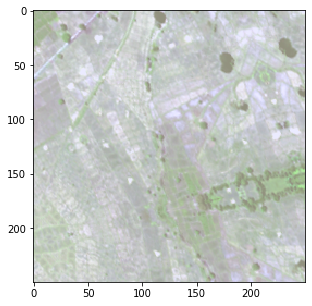

In [5]:
img = train_dataset[0]
I = img[0].numpy().transpose(1, 2, 0)
plt.imshow((I + 1)/2)

In [6]:
print(len(train_dataset))
print(len(test_dataset))

4130
1044


In [7]:
img[1]

3

In [8]:
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=10, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=10, num_workers=4)

In [9]:
img, rpr10, rpr40, avg_cons = next(iter(train_loader))

In [10]:
rpr10.dtype

torch.int64

In [11]:
img.shape

torch.Size([10, 3, 250, 250])

In [12]:
def calc_statistics():
    I = []
    y = 0
    for data in train_loader:
        imgs = data[0]
        I.append(imgs)
        y += imgs.shape[0]
        if y > 1000:
            break
    I = torch.cat(I, dim=0)
    mean = I.mean(dim=(0, -2, -1))
    std = I.std(dim=(0, -2, -1))
    return mean, std

In [13]:
mean, std = calc_statistics()

In [14]:
print(mean, std)

tensor([0.3716, 0.4122, 0.2568]) tensor([0.2126, 0.2077, 0.2278])


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# device = torch.device('cuda')
device = torch.device('cpu')

In [16]:

import torchvision.models as models

def pretrained_resnet_features_extractor(backend):
    feature_extractor = getattr(models, backend)(pretrained=True)
    cnn = nn.Sequential(
        feature_extractor.conv1,
        feature_extractor.bn1,
        feature_extractor.relu,
        feature_extractor.maxpool,
        feature_extractor.layer1,
        feature_extractor.layer2,
        feature_extractor.layer3,
        feature_extractor.layer4
    )
    return cnn 

In [17]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.featuresExtractor = pretrained_resnet_features_extractor("resnet50") 
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.backbone = nn.Sequential(
            nn.Linear(2048, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 14)            
        )
        
    def forward(self, x):
        x = self.featuresExtractor(x)
        x = self.pool(x).flatten(start_dim=1)
        x = self.backbone(x)
        return x

In [18]:
model = Net().to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

In [19]:
criterion = nn.CrossEntropyLoss()

In [20]:
data = next(iter(train_loader))
img = data[0].to(device)
result = model(img)
result.shape

torch.Size([10, 14])

In [21]:
mean_ = mean[None, :, None, None].to(device)
std_ = std[None, :, None, None].to(device)


In [22]:
criterion(result, data[1].to(device))

tensor(2.3032, grad_fn=<NllLossBackward>)

In [23]:
def train(epoch):
    print("Training...")
    total_loss = 0
    N = 0
    model.train()
    for data in train_loader:
        optimizer.zero_grad()
        imgs = data[0].to(device)
        imgs -= mean_
        imgs /= std_
        tgts = data[1].to(device)
        result = model(imgs)
        loss = criterion(result, tgts)
        total_loss += loss.item()
        N += imgs.shape[0]
        loss.backward()
        optimizer.step()
    print("Train epoch " + str(epoch) + " Loss: " + str(total_loss/N))

In [24]:
def test(epoch):
    print("Testing...")
    total_loss = 0
    N = 0
    model.eval()
    for data in train_loader:
        with torch.no_grad():
            imgs = data[0].to(device)
            imgs -= mean_
            imgs /= std_
            tgts = data[1].to(device)
            result = model(imgs)
            loss = criterion(result, tgts)
            total_loss += loss.item()
            N += imgs.shape[0]
    print("Testing epoch " + str(epoch) + " Loss: " + str(total_loss/N))
    return total_loss/N

In [25]:
model_file = "cl_new_2020-03-25 23:55.torch"

try:
    checkpoint = torch.load(model_file)
    best_epoch = checkpoint['epoch']
    best_loss = checkpoint['loss']
    saved_loss = best_loss
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    del checkpoint
    print("Training from checkpoint " + model_file + " Loss: " + str(best_loss) + "..." )
except:    
    best_loss = sp.inf
    saved_loss = best_loss
    best_epoch = 0
    print("Training from scratch...")

Training from scratch...


In [ ]:
import datetime

for epoch in range(best_epoch, 100):
    train(epoch)
    loss = test(epoch)
    if loss < best_loss:
        print("Best iteration.")
        best_loss = loss
        best_epoch = epoch
        if loss/saved_loss < 0.97:
            import datetime
            saved_loss = loss
            model_file = "cl_new_" + datetime.datetime.now().strftime("%Y-%m-%d %H:%M") + ".torch"
            torch.save({
            'epoch': epoch,
            'loss': loss,    
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            }, model_file)
            print("Model saved at " + model_file + ".")
    else:
        if epoch - best_epoch > 10:
            print("Early stop.")
            break    

Training...
Train epoch 0 Loss: 0.1578229298170196
Testing...
Testing epoch 0 Loss: 0.12322324785712845
Best iteration.
Model saved at cl_new_2020-03-25 20:17.torch.
Training...
Train epoch 1 Loss: 0.12676322760362602
Testing...
Testing epoch 1 Loss: 0.11801014080751895
Best iteration.
Model saved at cl_new_2020-03-26 00:40.torch.
Training...
Train epoch 2 Loss: 0.1189181585000156
Testing...
Testing epoch 2 Loss: 0.1072548431432276
Best iteration.
Model saved at cl_new_2020-03-26 11:09.torch.
Training...
Train epoch 3 Loss: 0.11388069362386376
Testing...
Testing epoch 3 Loss: 0.1060766238349402
Best iteration.
Training...
Train epoch 4 Loss: 0.11069779772735393
Testing...
Testing epoch 4 Loss: 0.10539823735164383
Best iteration.
Training...
Train epoch 5 Loss: 0.10847128367019912
Testing...
Testing epoch 5 Loss: 0.0965677247209064
Best iteration.
Model saved at cl_new_2020-03-26 15:33.torch.
Training...
Train epoch 6 Loss: 0.10656001520214589
Testing...
Testing epoch 6 Loss: 0.09624782

In [ ]:
imgs, rpr10, rpr40, avg_cons = next(iter(test_loader))

In [ ]:
imgs = imgs.to(device)
imgs -= mean_
imgs /= std_
model.eval()
with torch.no_grad():
    results = model(imgs.to(device))

In [ ]:
rpr10[:, None]

In [ ]:
results.argmax(dim=1)[:, None]

In [ ]:
rpr10 = rpr10.to(device)

In [ ]:
100*(results.flatten() - rpr10.flatten()).abs()/(rpr10.flatten())